In [292]:
'''
Keras: https://keras.io/getting_started/
https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2
https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce
'''
'''
From this notebook: https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%201%20-%20Artificial%20Neural%20Networks.ipynb
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
from keras.callbacks import EarlyStopping

In [280]:
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim(min(X[:, 0])-0.1, max(X[:, 0])+0.1)
    plt.ylim(min(X[:, 1])-0.1, max(X[:, 1])+0.1)
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y    

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('accuracy', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])    

[[-4.09049818  2.07274152]]
[-0.27800528]
[-2  2]
[-3.81282036  4.08106922]


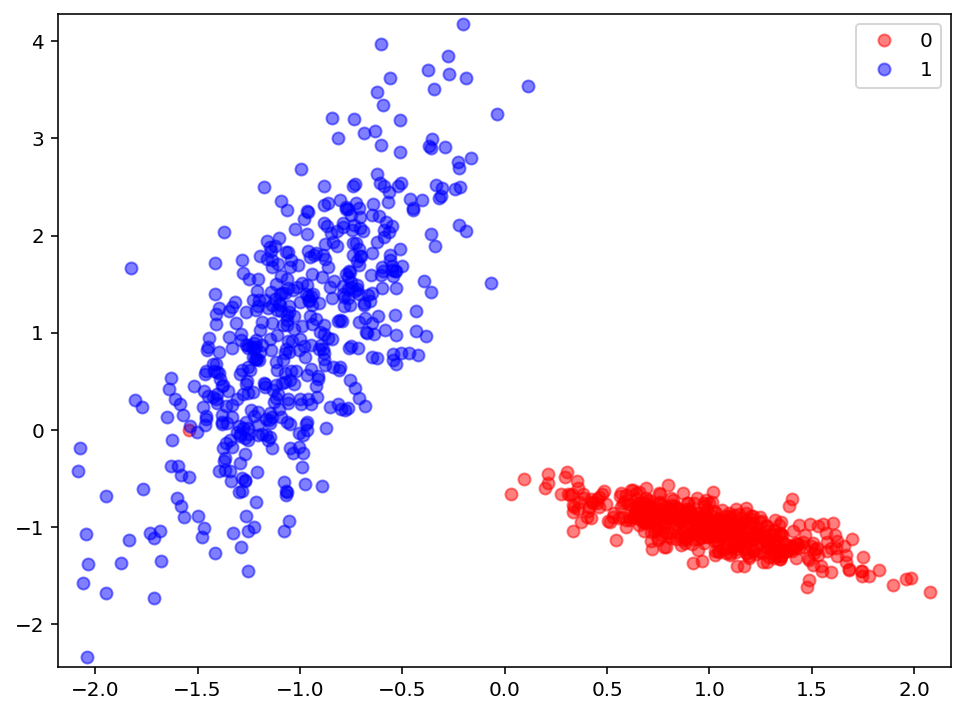

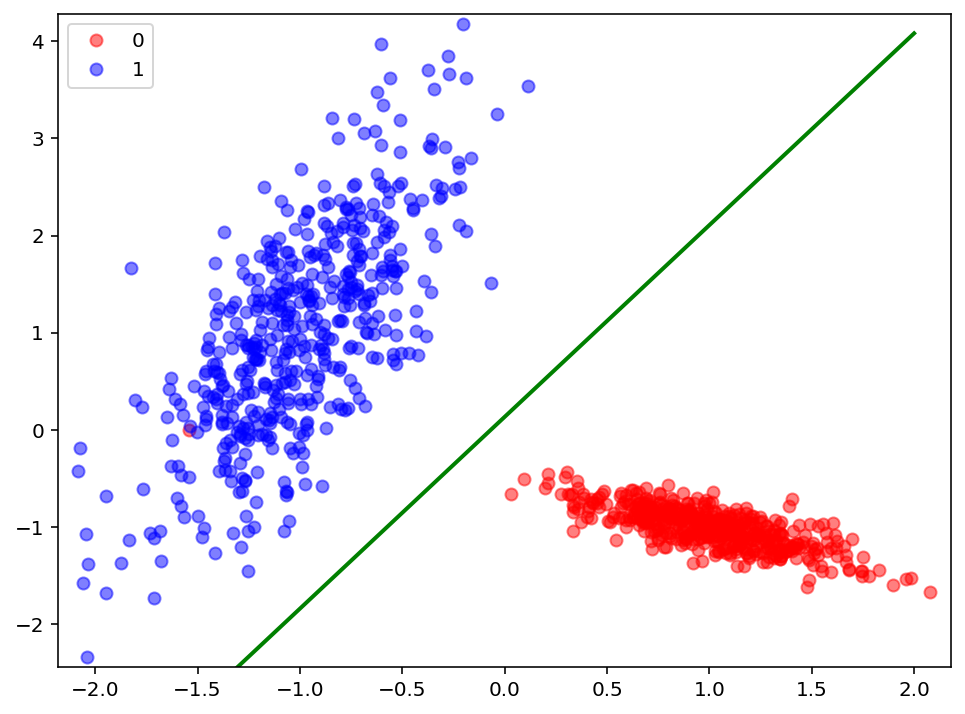

In [40]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

lr = LogisticRegression()
lr.fit(X, y)
print(lr.coef_)
print(lr.intercept_)
plot_data(X, y)

limits = np.array([-2, 2])
print(limits)
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
print(boundary)
plt.plot(limits, boundary, "g-", linewidth=2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       501
           1       1.00      1.00      1.00       499

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



<Figure size 576x432 with 0 Axes>

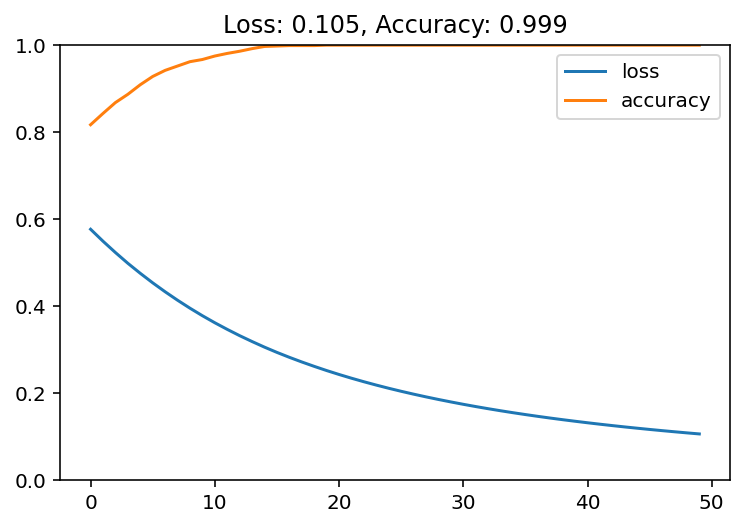

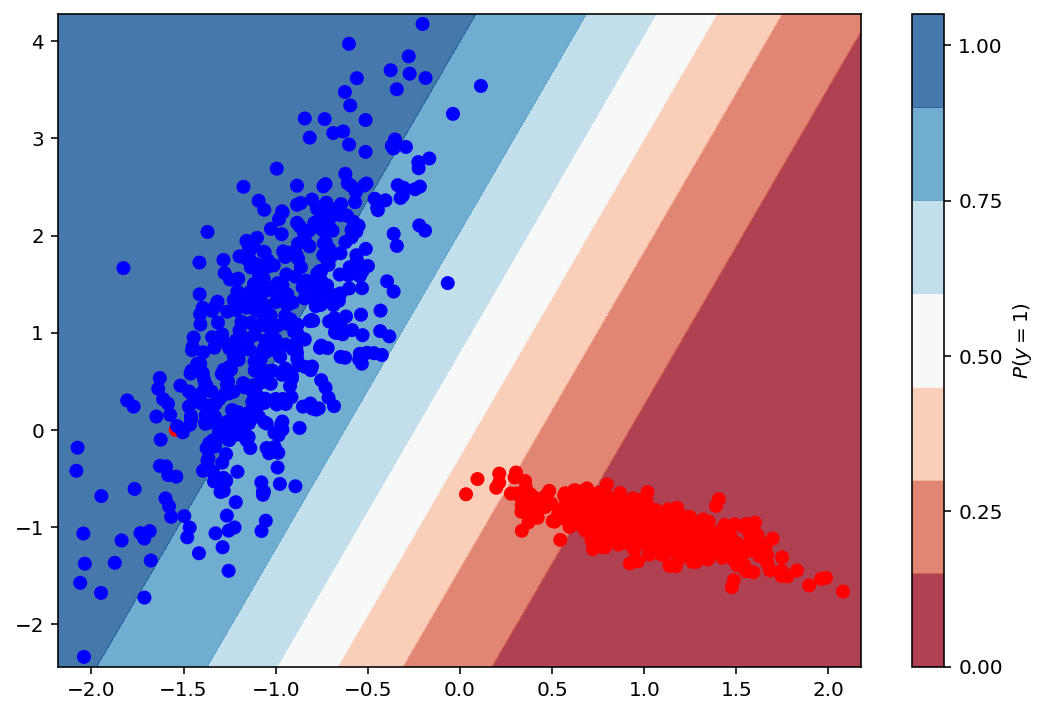

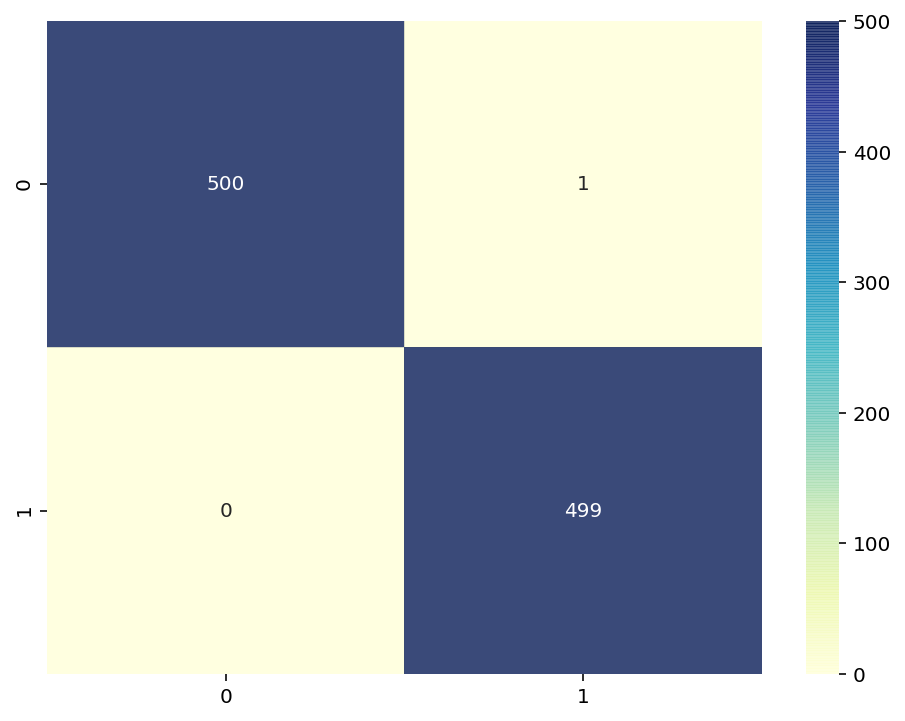

In [41]:
'''
While building Keras models for logistic regression, we perform the following steps:
Step 1: Define a Sequential model.</p>
Step 2: Add a Dense layer with sigmoid activation function. This was the only layer we needed.</p>
Step 3: Compile the model with an optimizer and loss function.</p>
Step 4: Fit the model to the dataset.</p>
Step 5: Analyze the results: plotting loss/accuracy curves, plotting the decision boundary, looking at the classification report, and understanding the confusion matrix.</p>
'''
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=0, epochs=50)
plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

plot_confusion_matrix(model, X, y)

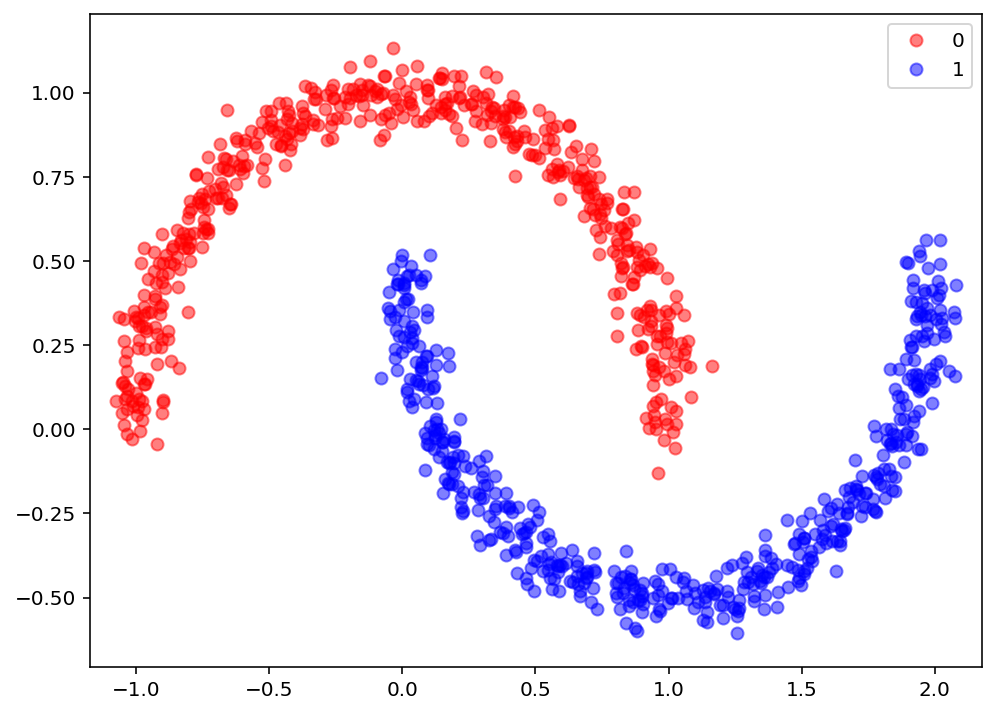

In [48]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

<Figure size 576x432 with 0 Axes>

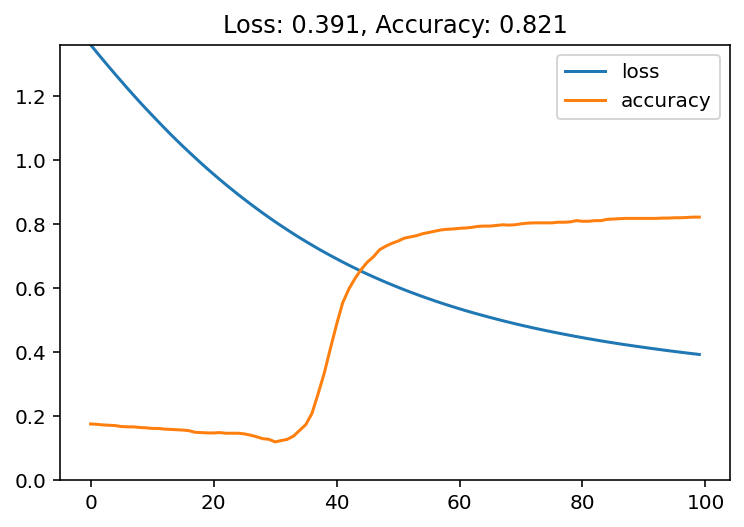

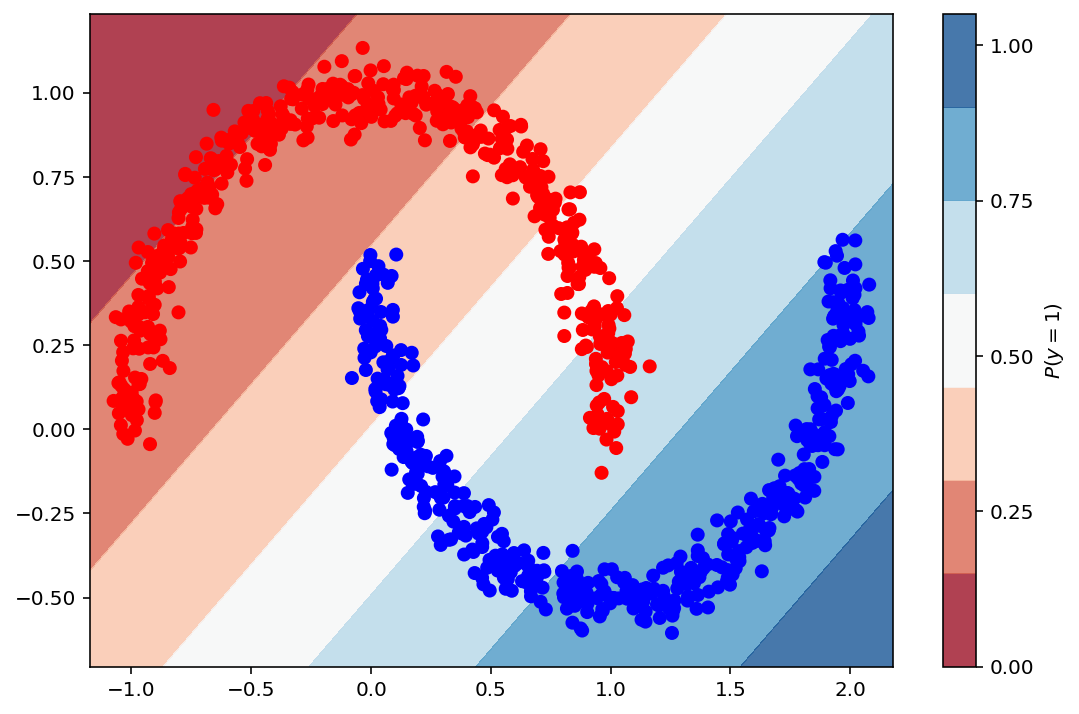

In [49]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))
model.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       500
           1       0.82      0.83      0.82       500

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



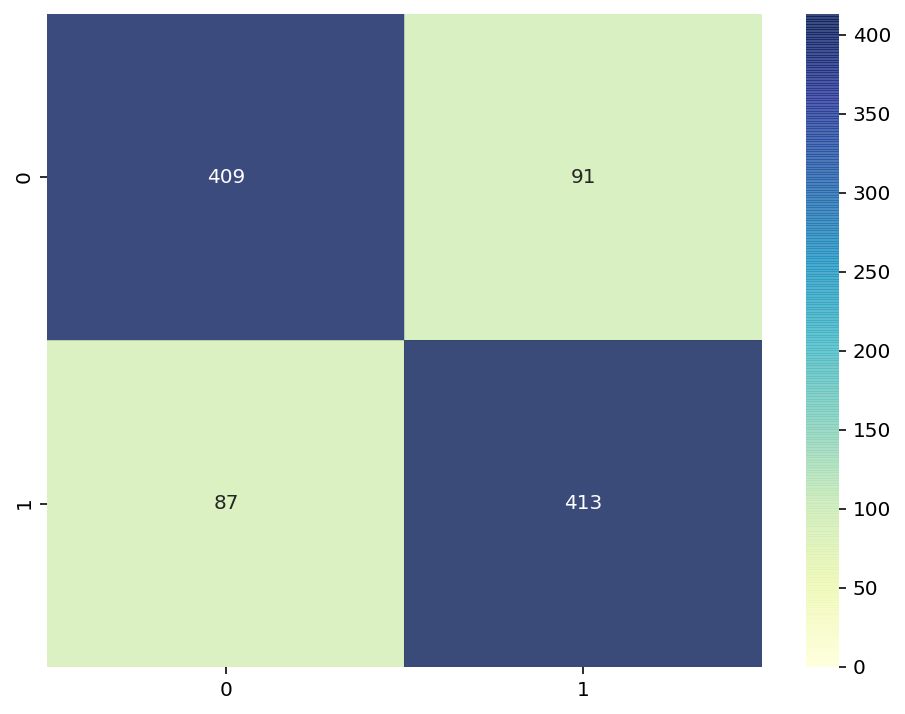

In [50]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

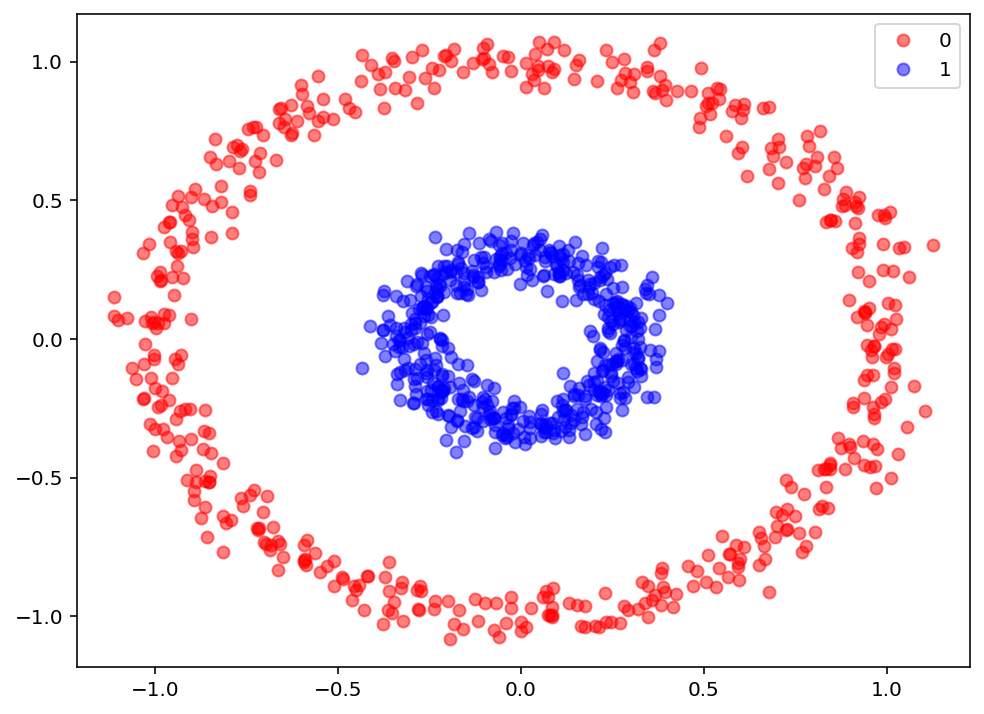

In [55]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

<Figure size 576x432 with 0 Axes>

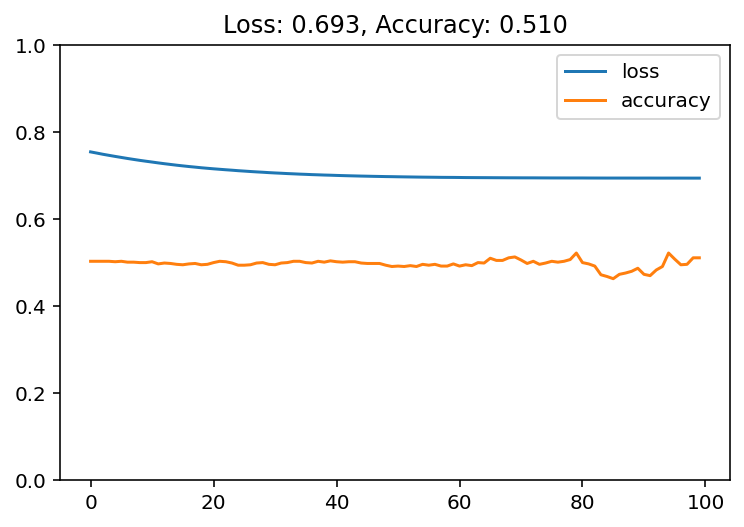

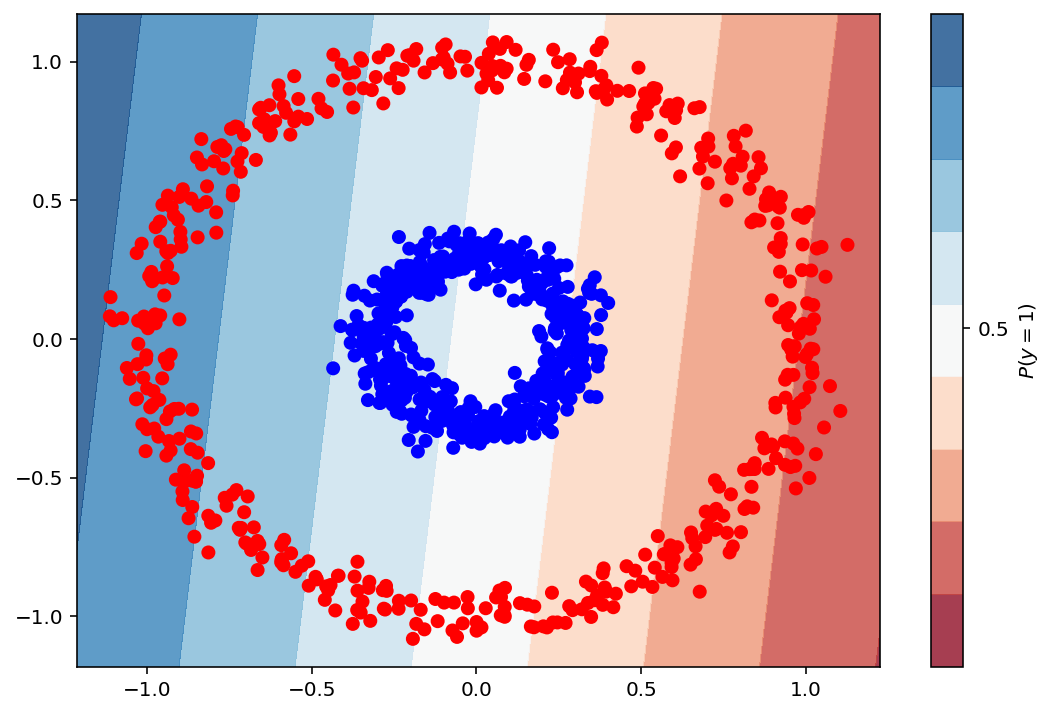

In [57]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)

              precision    recall  f1-score   support

           0       0.52      0.49      0.50       500
           1       0.51      0.54      0.53       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.51      1000
weighted avg       0.52      0.52      0.51      1000



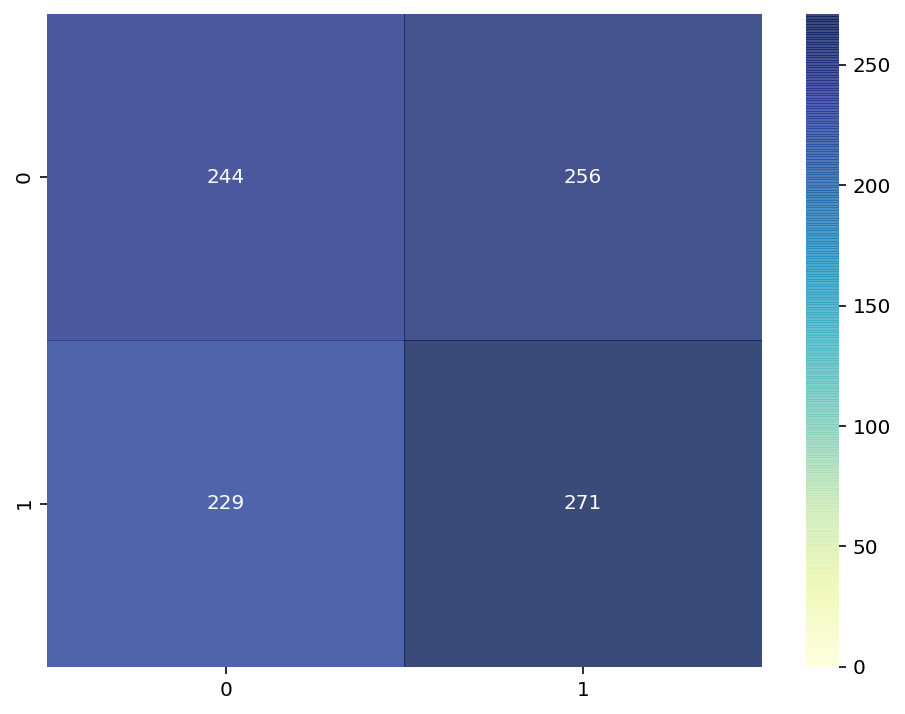

In [58]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

<Figure size 576x432 with 0 Axes>

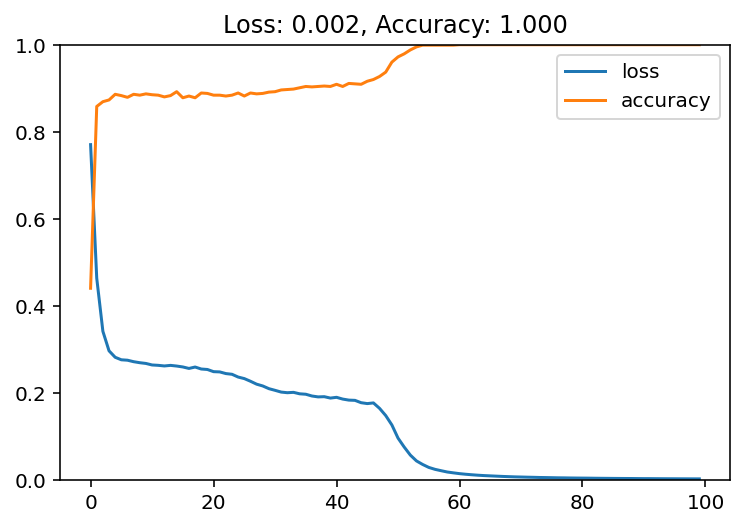

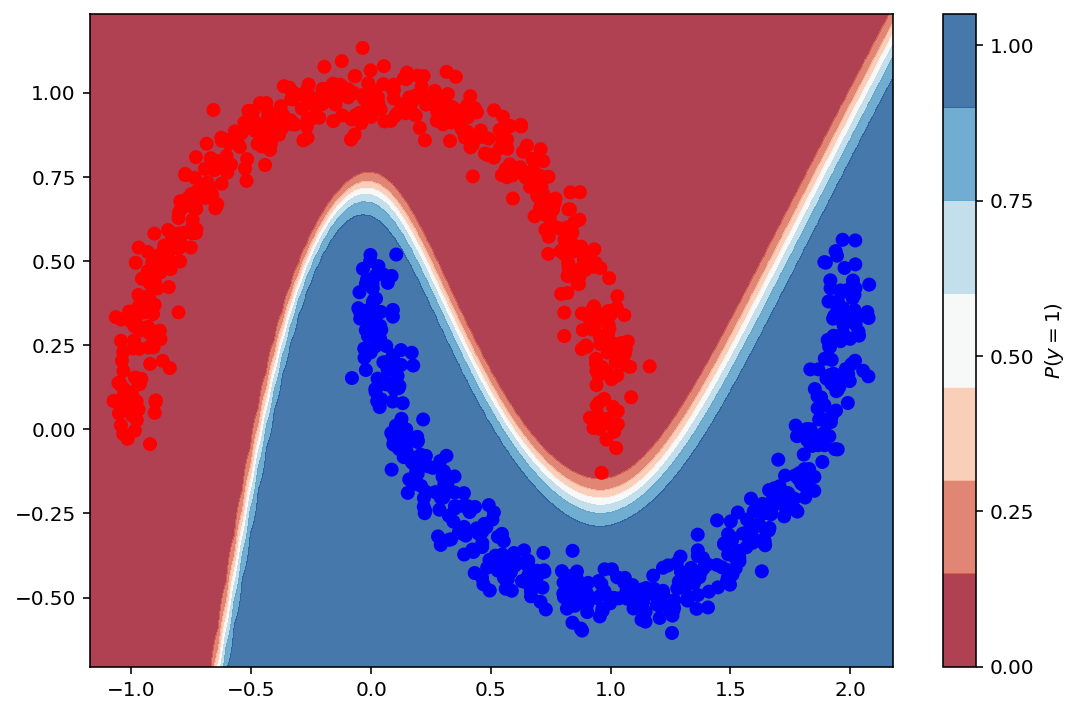

In [64]:
'''
This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:

1. Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
2. Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
3. We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.

We didn't build a very deep ANN here because it wasn't necessary. We already achieve perfect accuracy with this configuration.
'''
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy']) #lr = learning rate
history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



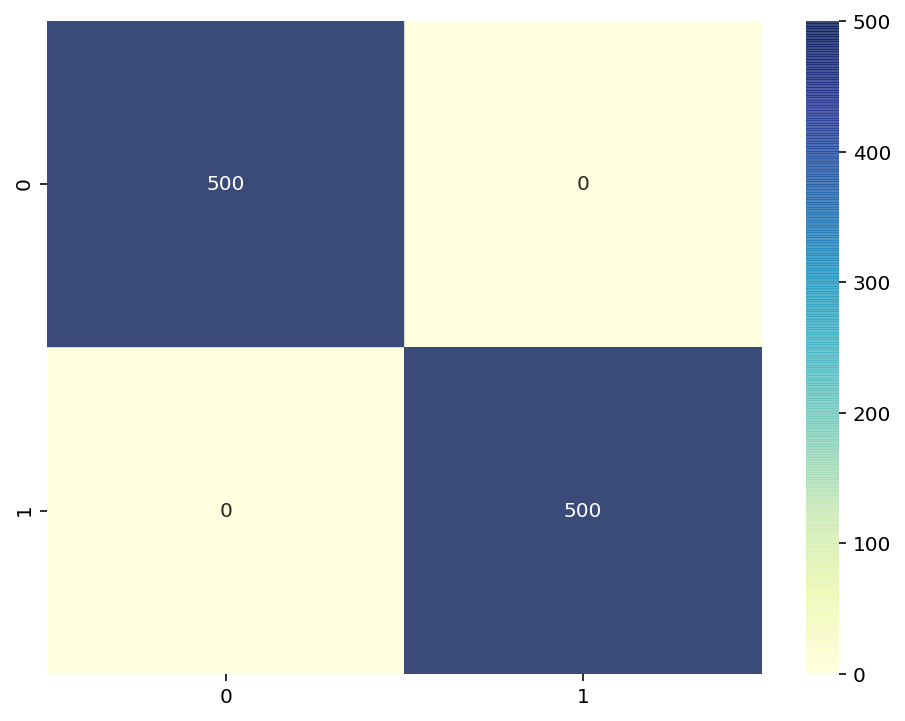

In [66]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

<Figure size 576x432 with 0 Axes>

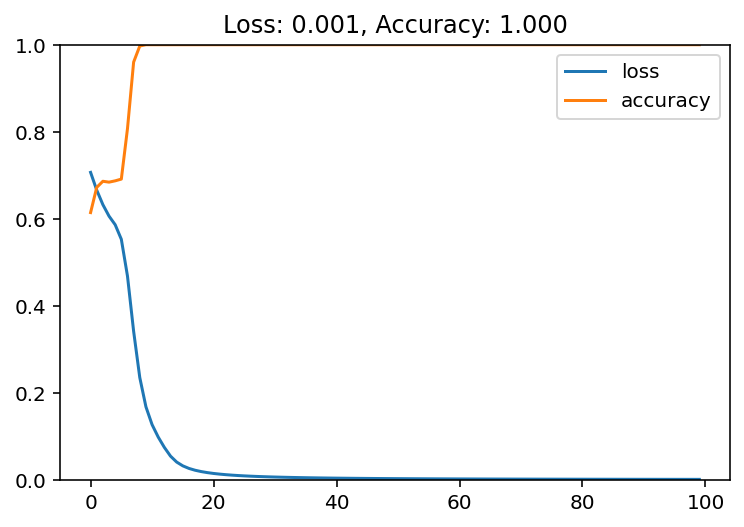

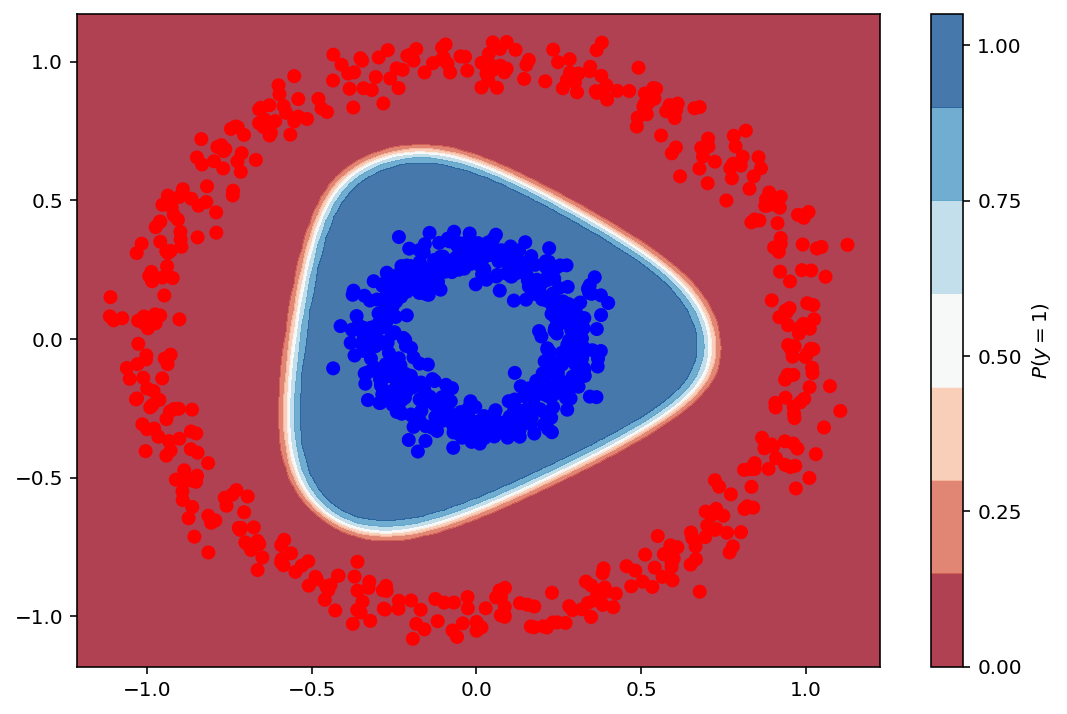

In [70]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=100, verbose=0)
plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



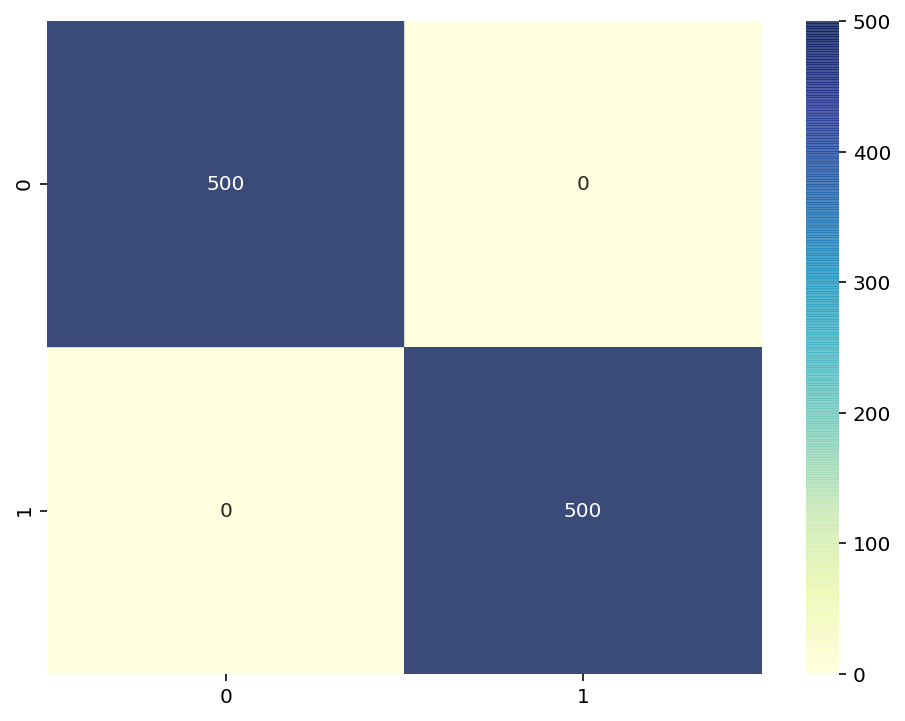

In [71]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

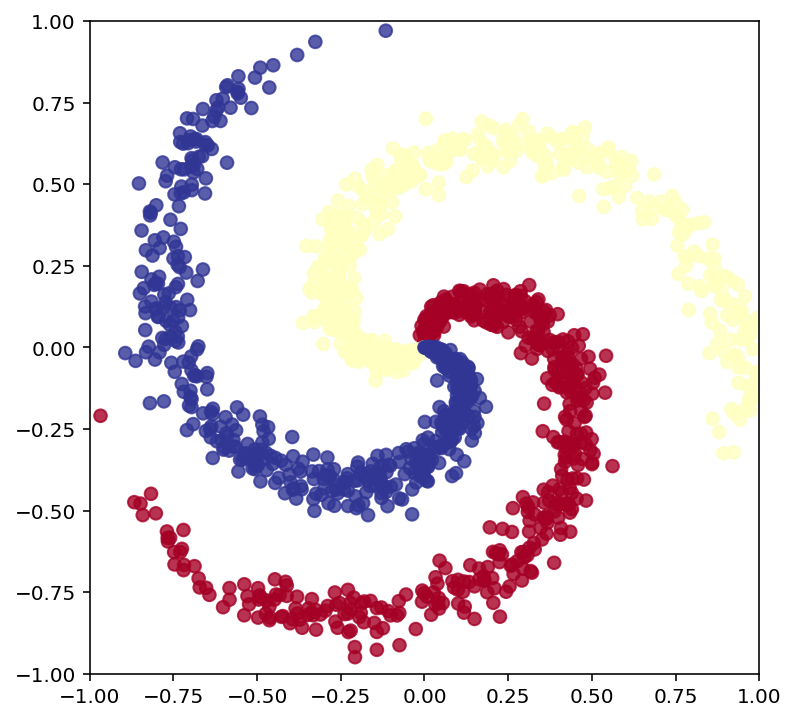

In [95]:
'''
In the previous sections we worked on a binary classification problem. 
Now we will take a look at a multi-class classification problem, where the number of classes is more than 2. 
We will pick 3 classes for demonstration, but our approach generalizes to any number of classes.

Softmax Regression
Logistic Regression (LR) is a classification method for 2 classes. It works with binary labels 0/1. 
Softmax Regression (SR) is a generalization of LR where we can have more than 2 classes. 
In our current dataset we have 3 classes, represented as 0/1/2.
'''

X, y = make_multiclass(K=3)

<Figure size 576x432 with 0 Axes>

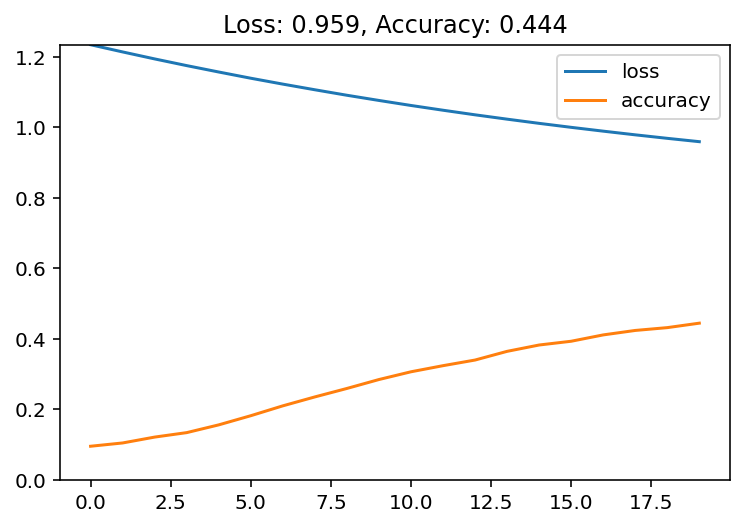

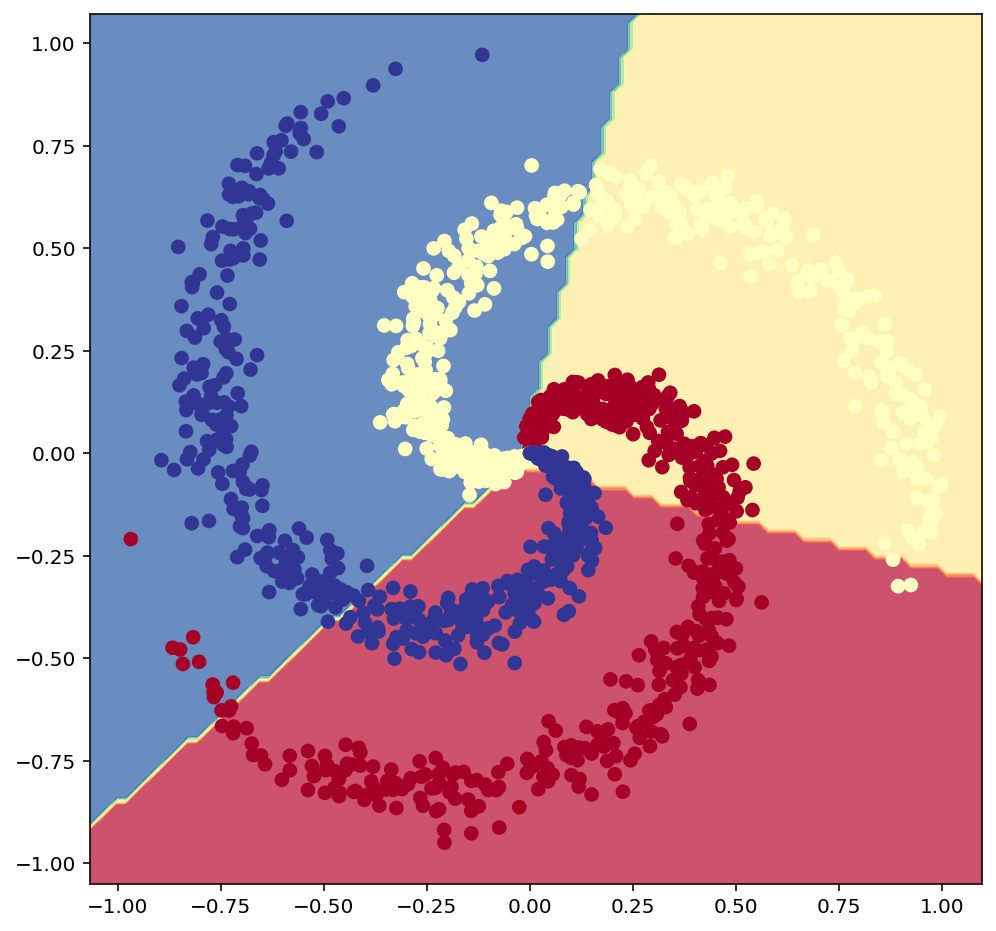

In [99]:
model = Sequential()
model.add(Dense(3, input_shape=(2,), activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=20)
plot_loss_accuracy(history)
plot_multiclass_decision_boundary(model, X, y)

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.50       500
         1.0       0.40      0.41      0.41       500
         2.0       0.42      0.43      0.43       500

    accuracy                           0.44      1500
   macro avg       0.44      0.44      0.44      1500
weighted avg       0.44      0.44      0.44      1500



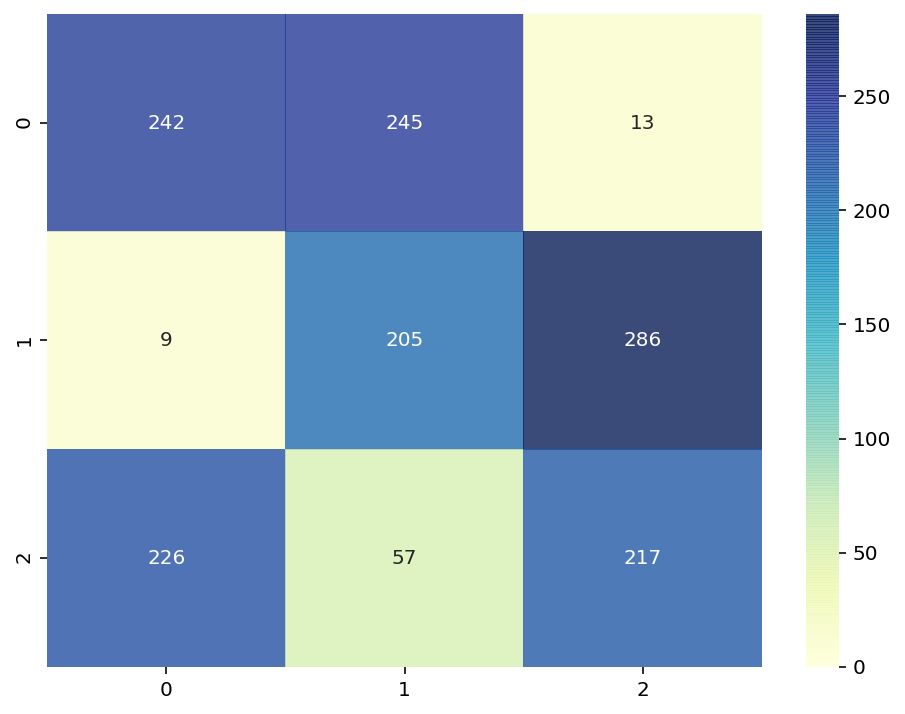

In [101]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

<Figure size 576x432 with 0 Axes>

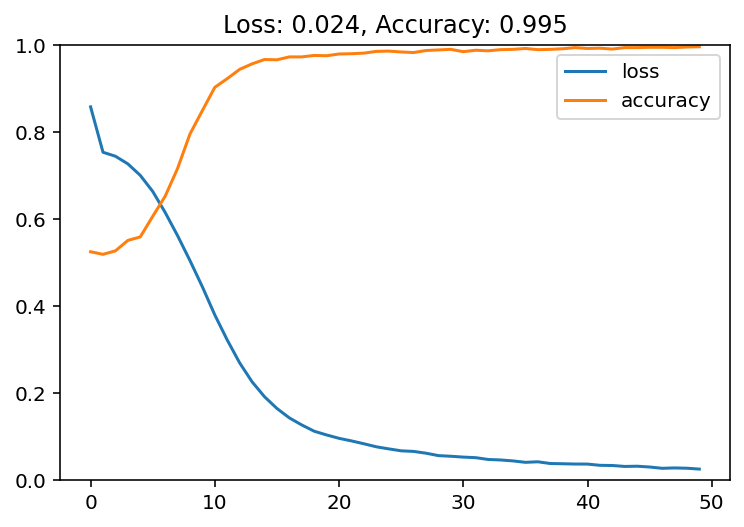

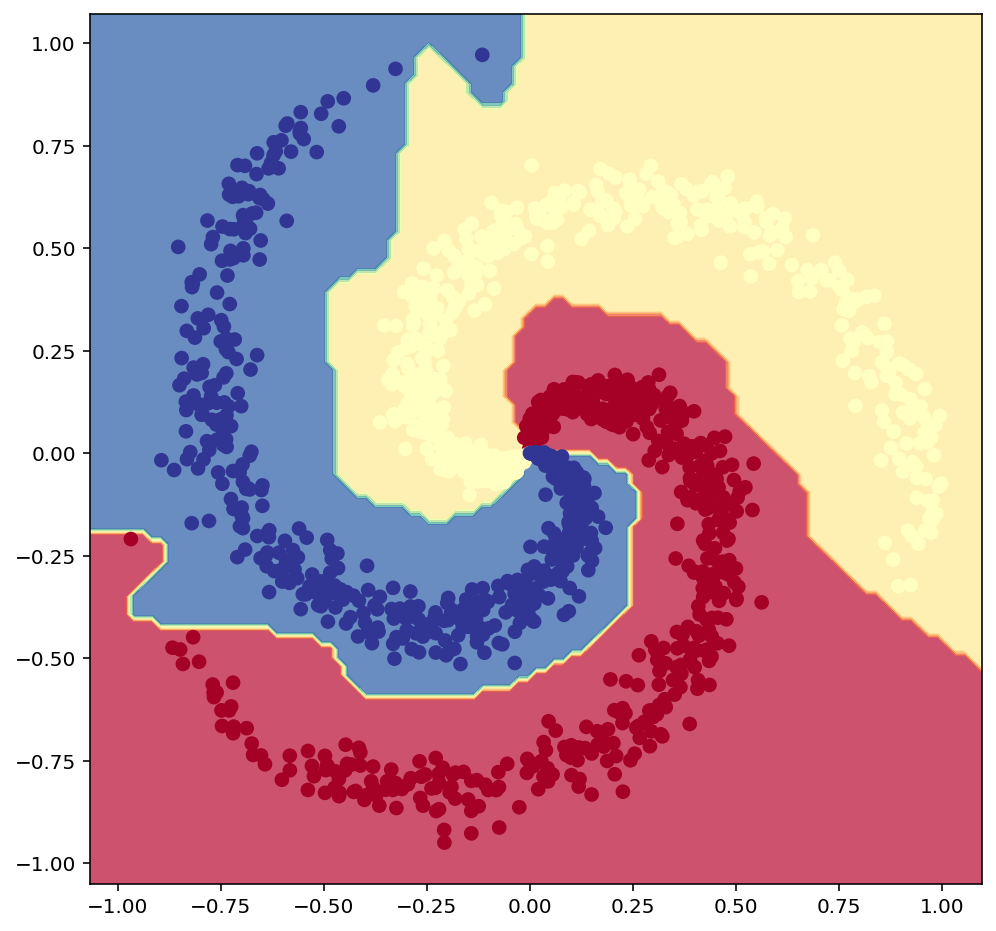

In [106]:
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y_cat, verbose=0, epochs=50)
plot_loss_accuracy(history)
plot_multiclass_decision_boundary(model, X, y)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       500
         1.0       0.99      1.00      1.00       500
         2.0       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



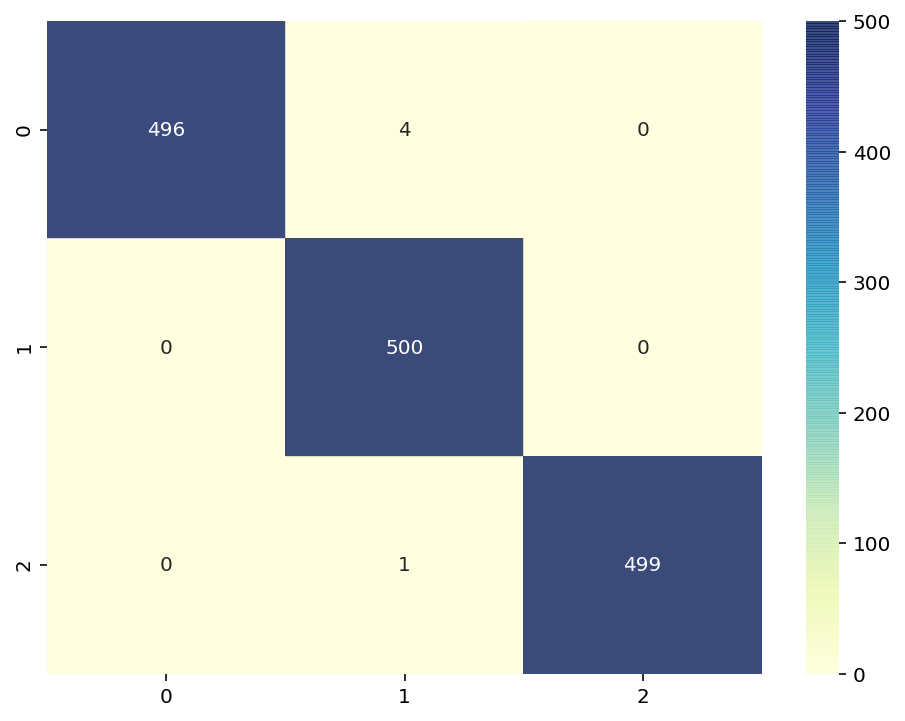

In [107]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

In [112]:
'''
Case Study - Binary Classification
We will be using the Human Resources Analytics dataset on Kaggle: https://www.kaggle.com/ludobenistant/hr-analytics

We're trying to predict whether an employee will leave based on various features such as number of projects they worked on, 
time spent at the company, last performance review, salary etc. The dataset has around 15,000 rows and 9 columns. 
The column we're trying to predict is called "left". It's a binary column with 0/1 values. 
The label 1 means that the employee has left.
'''
rawdf = pd.read_csv('HR.csv')
rawdf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [113]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   sales                  14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [114]:
rawdf.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [115]:
(rawdf['left'].value_counts())/rawdf['left'].count()

0    0.761917
1    0.238083
Name: left, dtype: float64

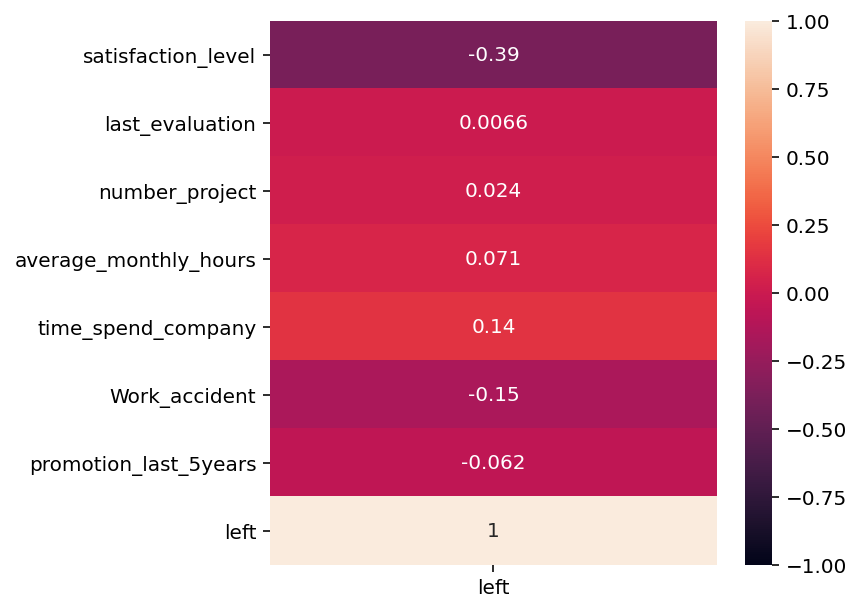

In [118]:
plt.figure(figsize = (5, 5))
sns.heatmap(rawdf.corr()[['left']], annot=True, vmin=-1, vmax=1)

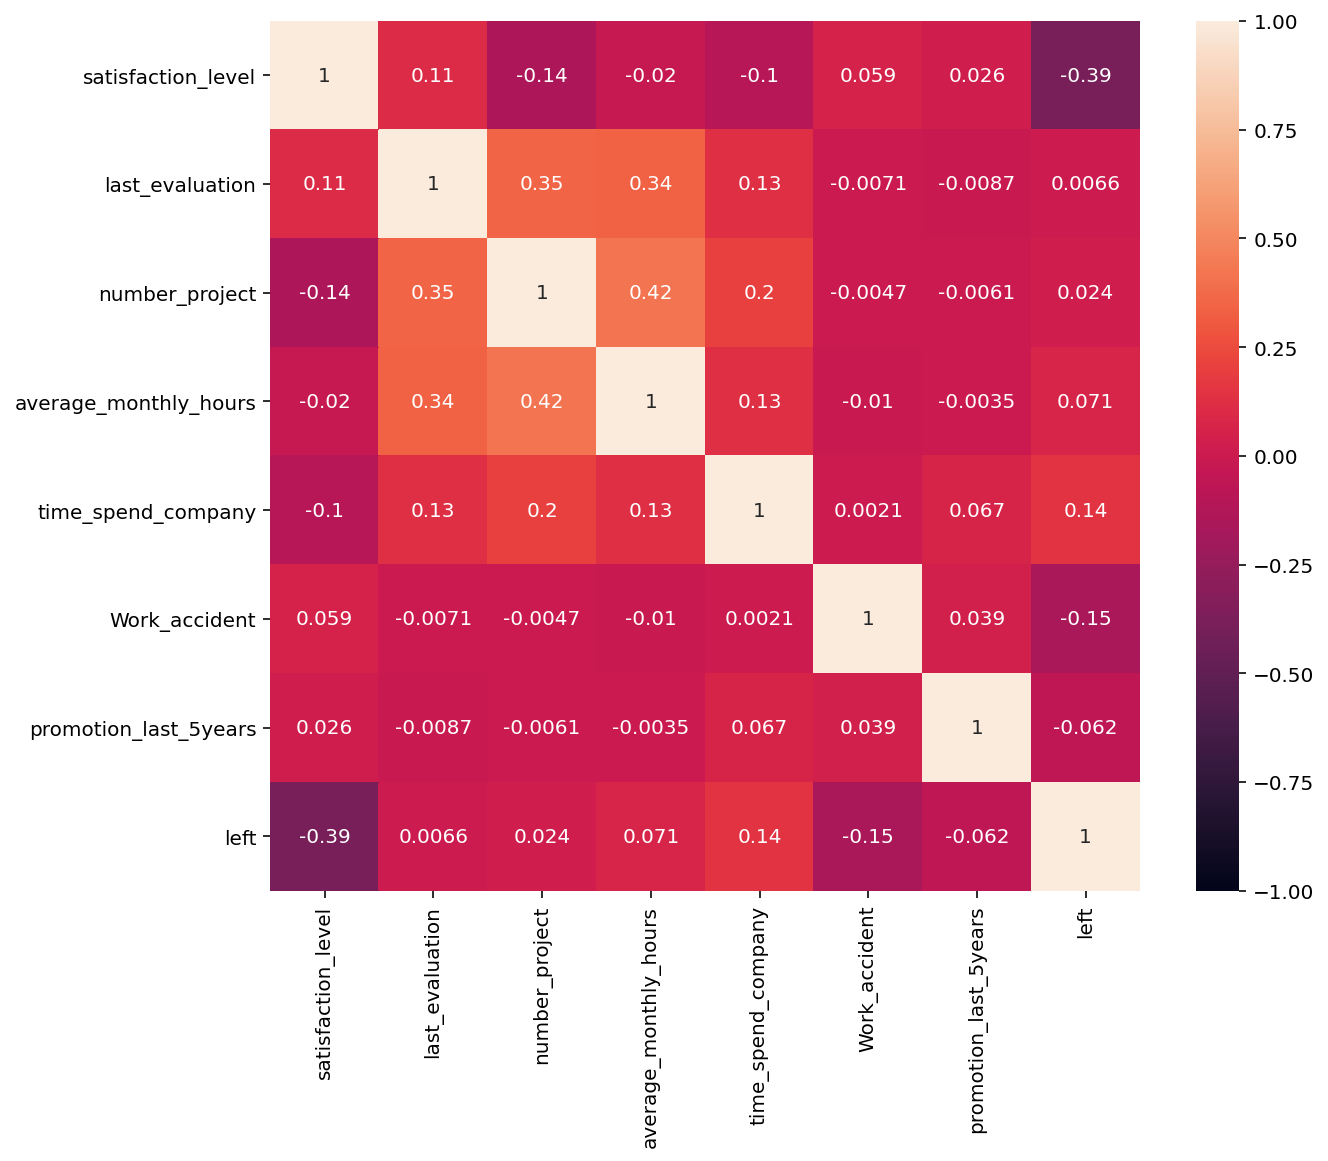

In [120]:
plt.figure(figsize=(10, 8))
sns.heatmap(rawdf.corr(), annot=True, square=True, vmin=-1, vmax=1)

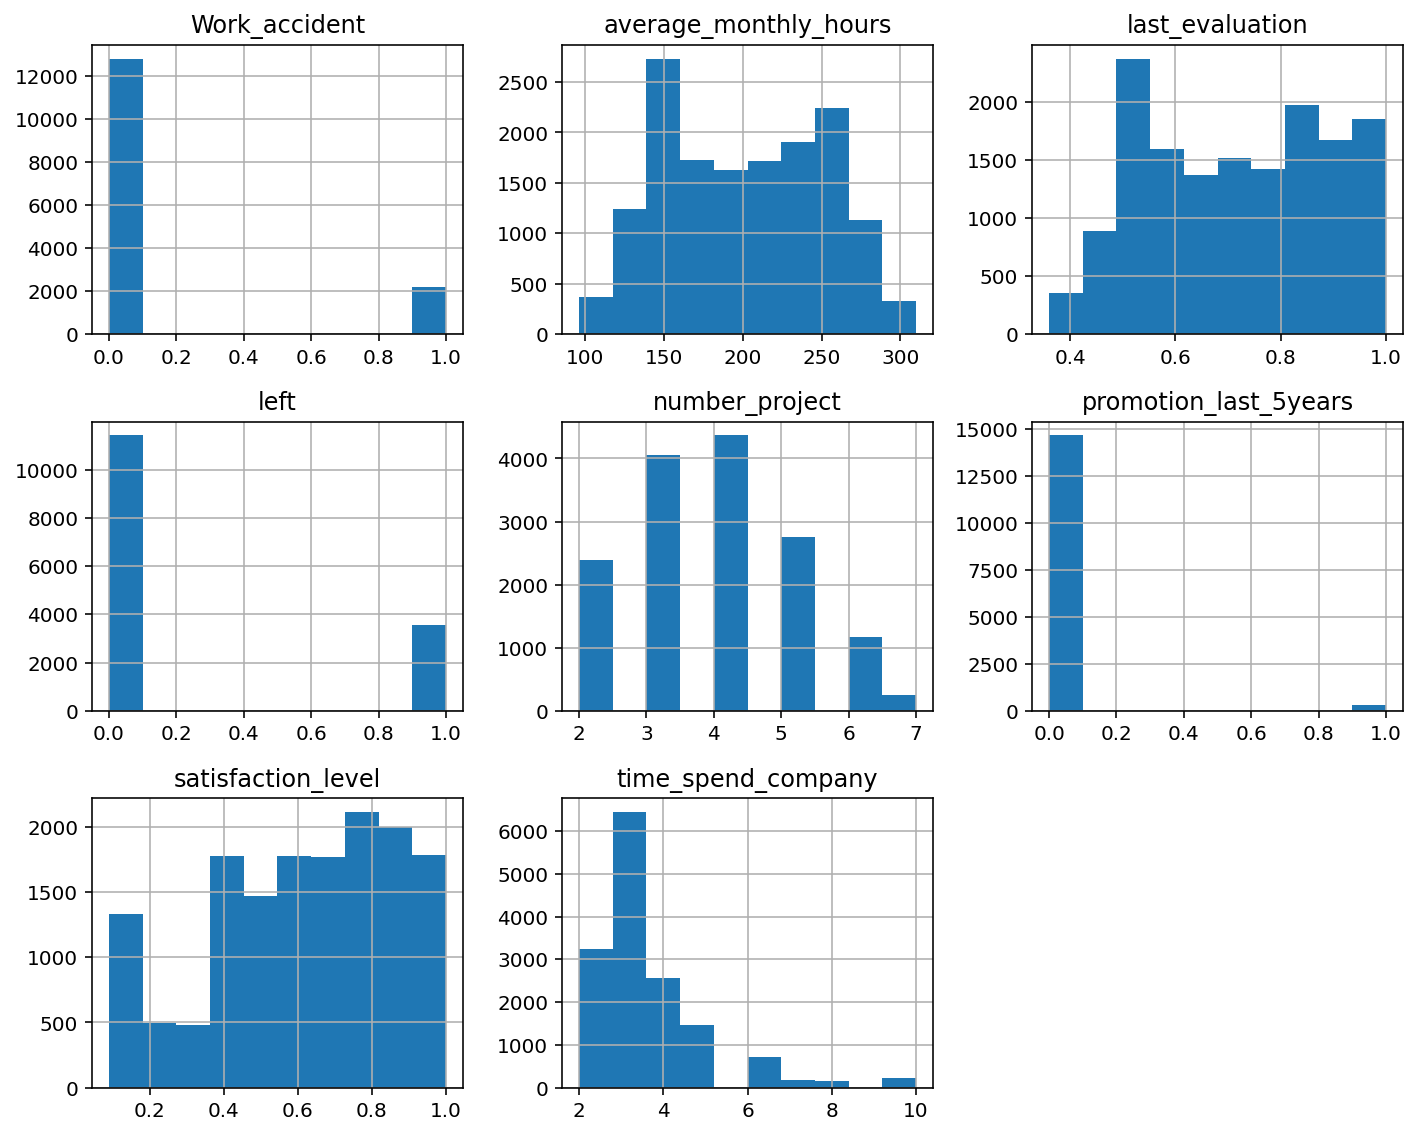

In [121]:
rawdf.hist(figsize=(10,8))
plt.tight_layout()

In [126]:
df = rawdf.copy()
ss = StandardScaler()
scale_features = ['average_monthly_hours', 'number_project', 'time_spend_company']
df[scale_features] = ss.fit_transform(df[scale_features])

categorical_features = ['sales', 'salary']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,-1.462863,-0.882040,-0.341235,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,0.971113,1.220423,1.713436,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,2.593763,1.420657,0.343655,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,0.971113,0.439508,1.028546,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,-1.462863,-0.841993,-0.341235,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [128]:
df.filter(regex=('salary.*')).head()

,salary_high,salary_low,salary_medium
0,0,1,0
1,0,0,1
2,0,0,1
3,0,1,0
4,0,1,0


In [129]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
count,14999.000000,14999.000000,1.499900e+04,1.499900e+04,1.499900e+04,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,...,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,5.589976e-17,-8.716572e-17,-6.063702e-17,0.144610,0.021268,0.238083,0.081805,0.052470,...,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.082472,0.487766,0.429762
std,0.248631,0.171169,1.000033e+00,1.000033e+00,1.000033e+00,0.351719,0.144281,0.425924,0.274077,0.222981,...,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.275092,0.499867,0.495059
min,0.090000,0.360000,-1.462863e+00,-2.103471e+00,-1.026126e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,-6.515376e-01,-9.020633e-01,-3.412352e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,1.597876e-01,-2.103137e-02,-3.412352e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,9.711129e-01,8.800240e-01,3.436553e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,2.593763e+00,2.181549e+00,4.452998e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
X = df.drop(['left'], axis=1).values
y = df['left'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # X=(data, features), y=(data, )

(10499, 20) (4500, 20) (10499,) (4500,)


<Figure size 576x432 with 0 Axes>

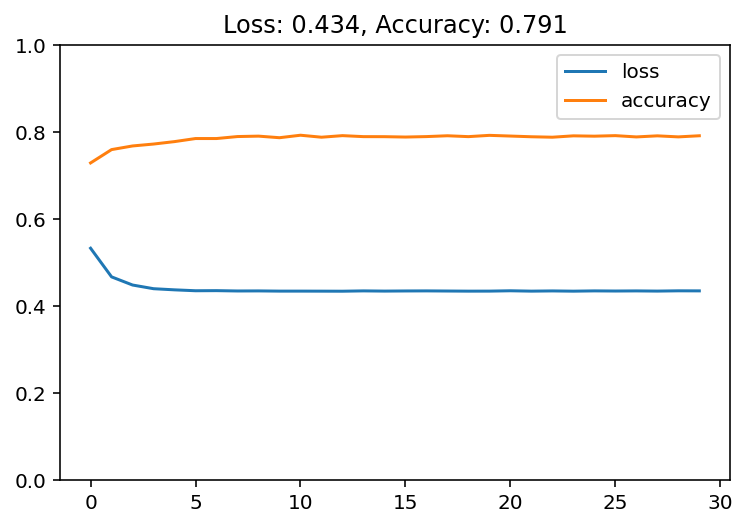

In [154]:
#Logistic regression
model = Sequential()
model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))
model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics = ['accuracy'])
lr_history = model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(lr_history)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3462
           1       0.57      0.33      0.42      1038

    accuracy                           0.79      4500
   macro avg       0.70      0.63      0.65      4500
weighted avg       0.76      0.79      0.77      4500



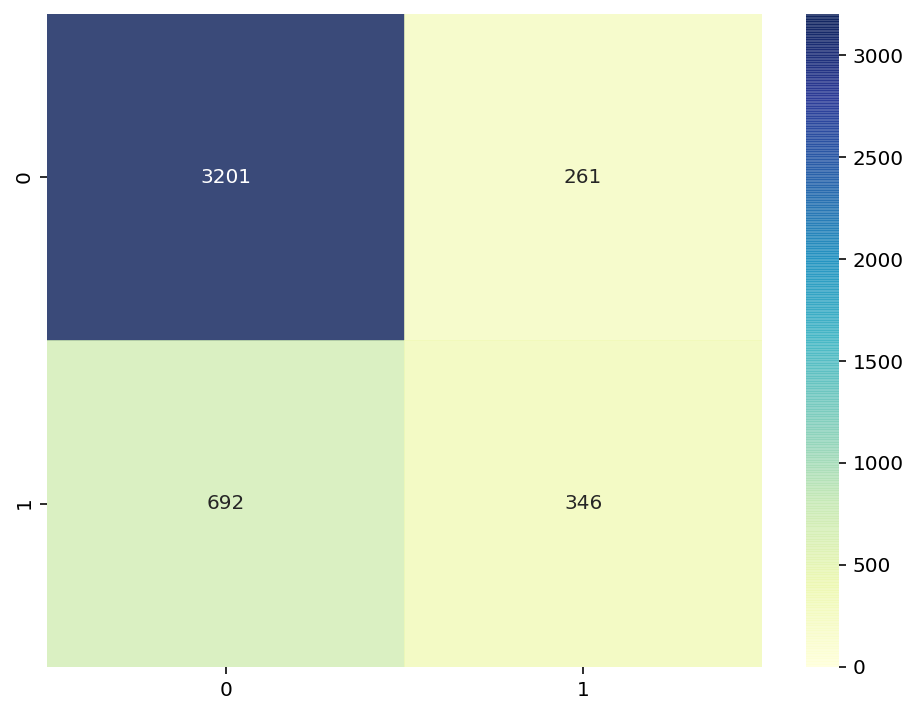

In [155]:
y_pred = model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test, y_test)

In [156]:
# using keras wrapper class 'KerasClassifier'
def get_model():
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))
    model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics = ['accuracy'])
    return model

new_X, new_y = shuffle(X, y, random_state=0)
model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, new_X, new_y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[0.77600002 0.80800003 0.77433336 0.77733332 0.77492499]
Accuracy: 78.21% (+/- 2.60%)


<Figure size 576x432 with 0 Axes>

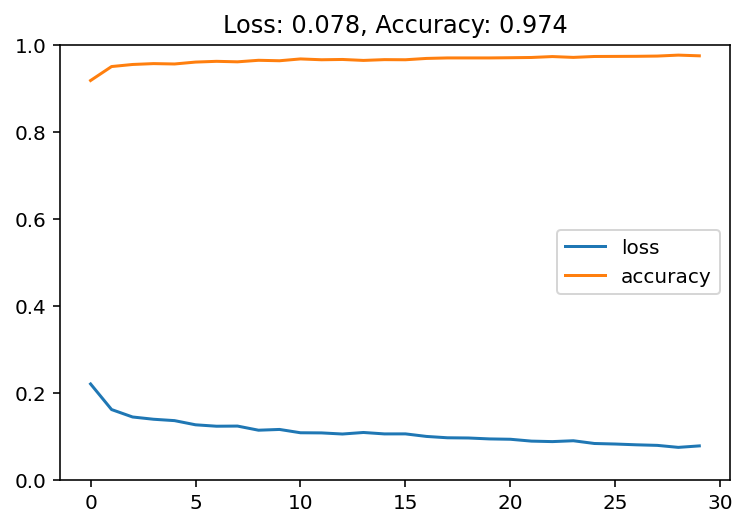

In [161]:
# Deep model
deep_model = Sequential()
deep_model.add(Dense(64, input_shape= (X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(32, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

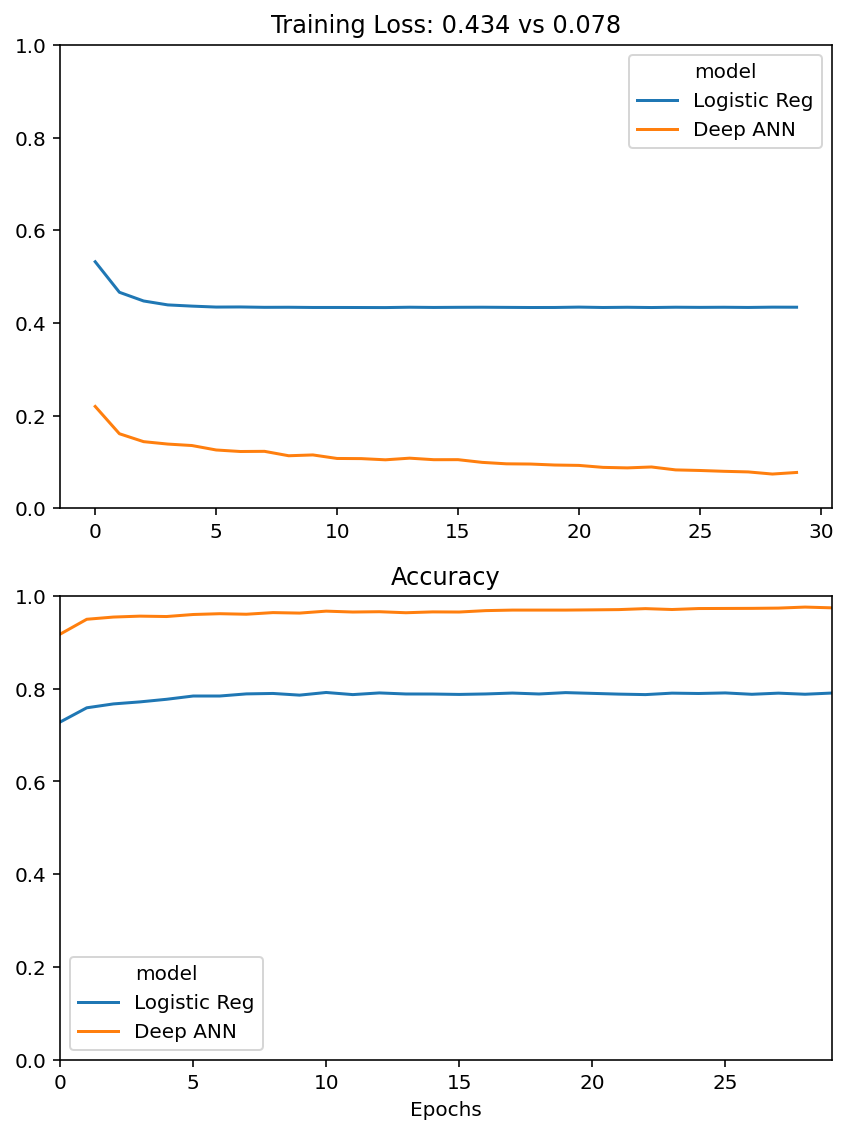

In [165]:
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep ANN'])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3462
           1       0.93      0.92      0.93      1038

    accuracy                           0.97      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.97      0.97      0.97      4500



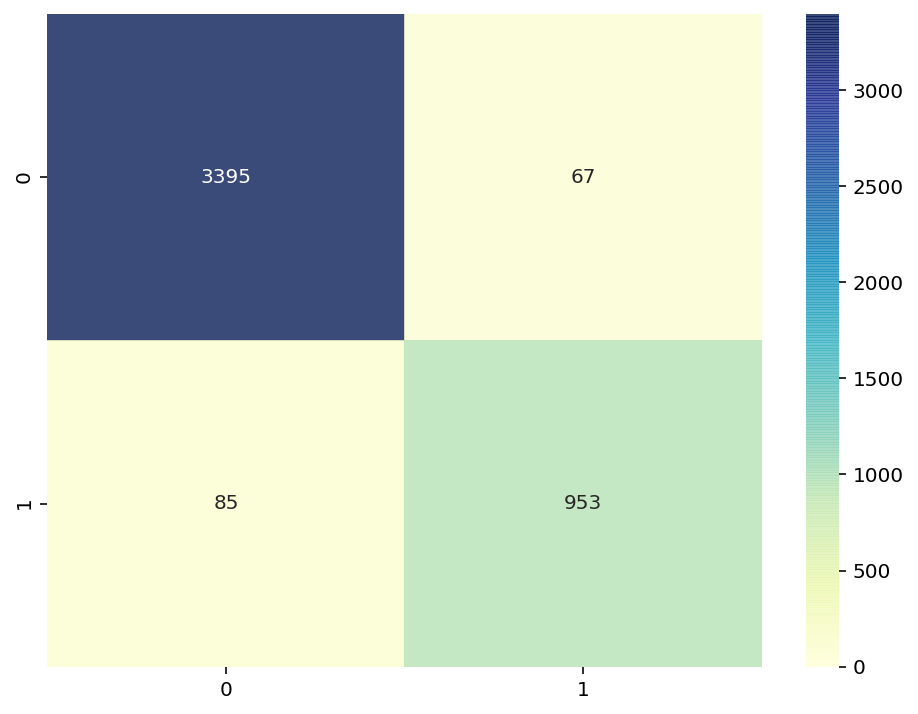

In [167]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

In [168]:
def get_model():
    return deep_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[0.90366668 0.97933334 0.96733332 0.99333334 0.96532178]
Accuracy: 96.18% (+/- 6.15%)


Epoch 1/10
329/329 [==============================] - 1s 2ms/step - loss: 0.2341 - accuracy: 0.9109
Epoch 2/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1562 - accuracy: 0.9516
Epoch 3/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1398 - accuracy: 0.9583
Epoch 4/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1356 - accuracy: 0.9574
Epoch 5/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1322 - accuracy: 0.9580
Epoch 6/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1218 - accuracy: 0.9616
Epoch 7/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1184 - accuracy: 0.9627
Epoch 8/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1168 - accuracy: 0.9617
Epoch 9/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1118 - accuracy: 0.9639
Epoch 10/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1076 - accuracy: 0.9642

<Figure size 576x432 with 0 Axes>

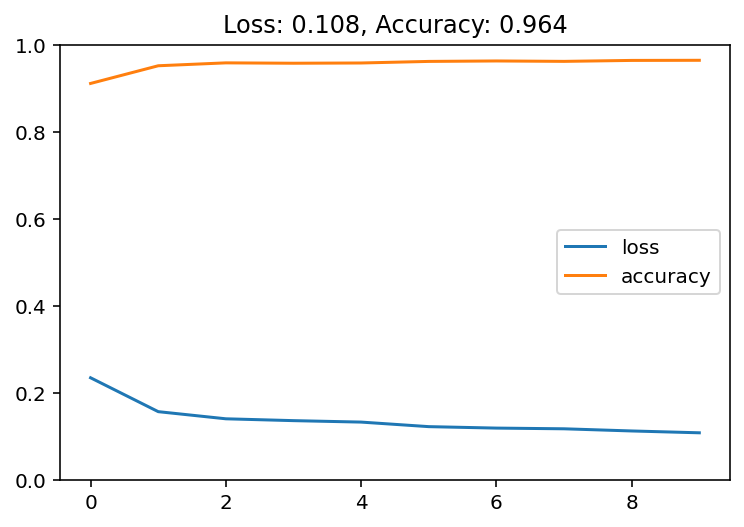

In [175]:
#Even deeper model
deeper_model = Sequential()
deeper_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deeper_model.add(Dense(64, activation='tanh'))
deeper_model.add(Dense(1, activation='sigmoid'))

deeper_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deeper_history = deeper_model.fit(X_train, y_train, verbose=1, epochs=10)
plot_loss_accuracy(deeper_history)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3462
           1       0.96      0.94      0.95      1038

    accuracy                           0.98      4500
   macro avg       0.97      0.96      0.96      4500
weighted avg       0.97      0.98      0.98      4500



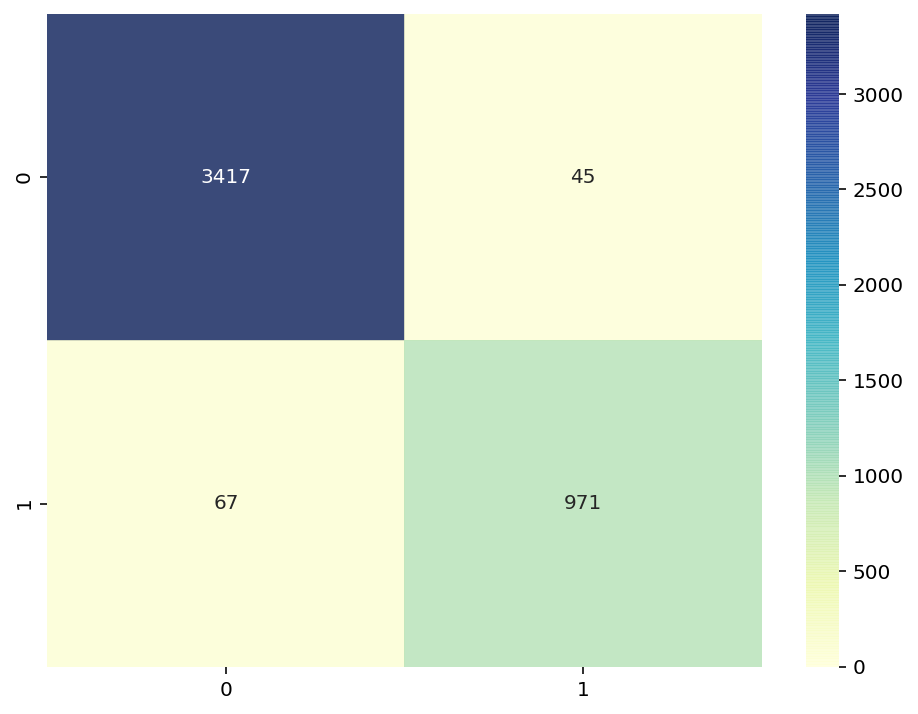

In [176]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

In [178]:
# Multiclass classification
df = pd.read_csv('iris.csv')
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,label
39,5.1,3.4,1.5,0.2,setosa
105,7.6,3.0,6.6,2.1,virginica
30,4.8,3.1,1.6,0.2,setosa
16,5.4,3.9,1.3,0.4,setosa
116,6.5,3.0,5.5,1.8,virginica


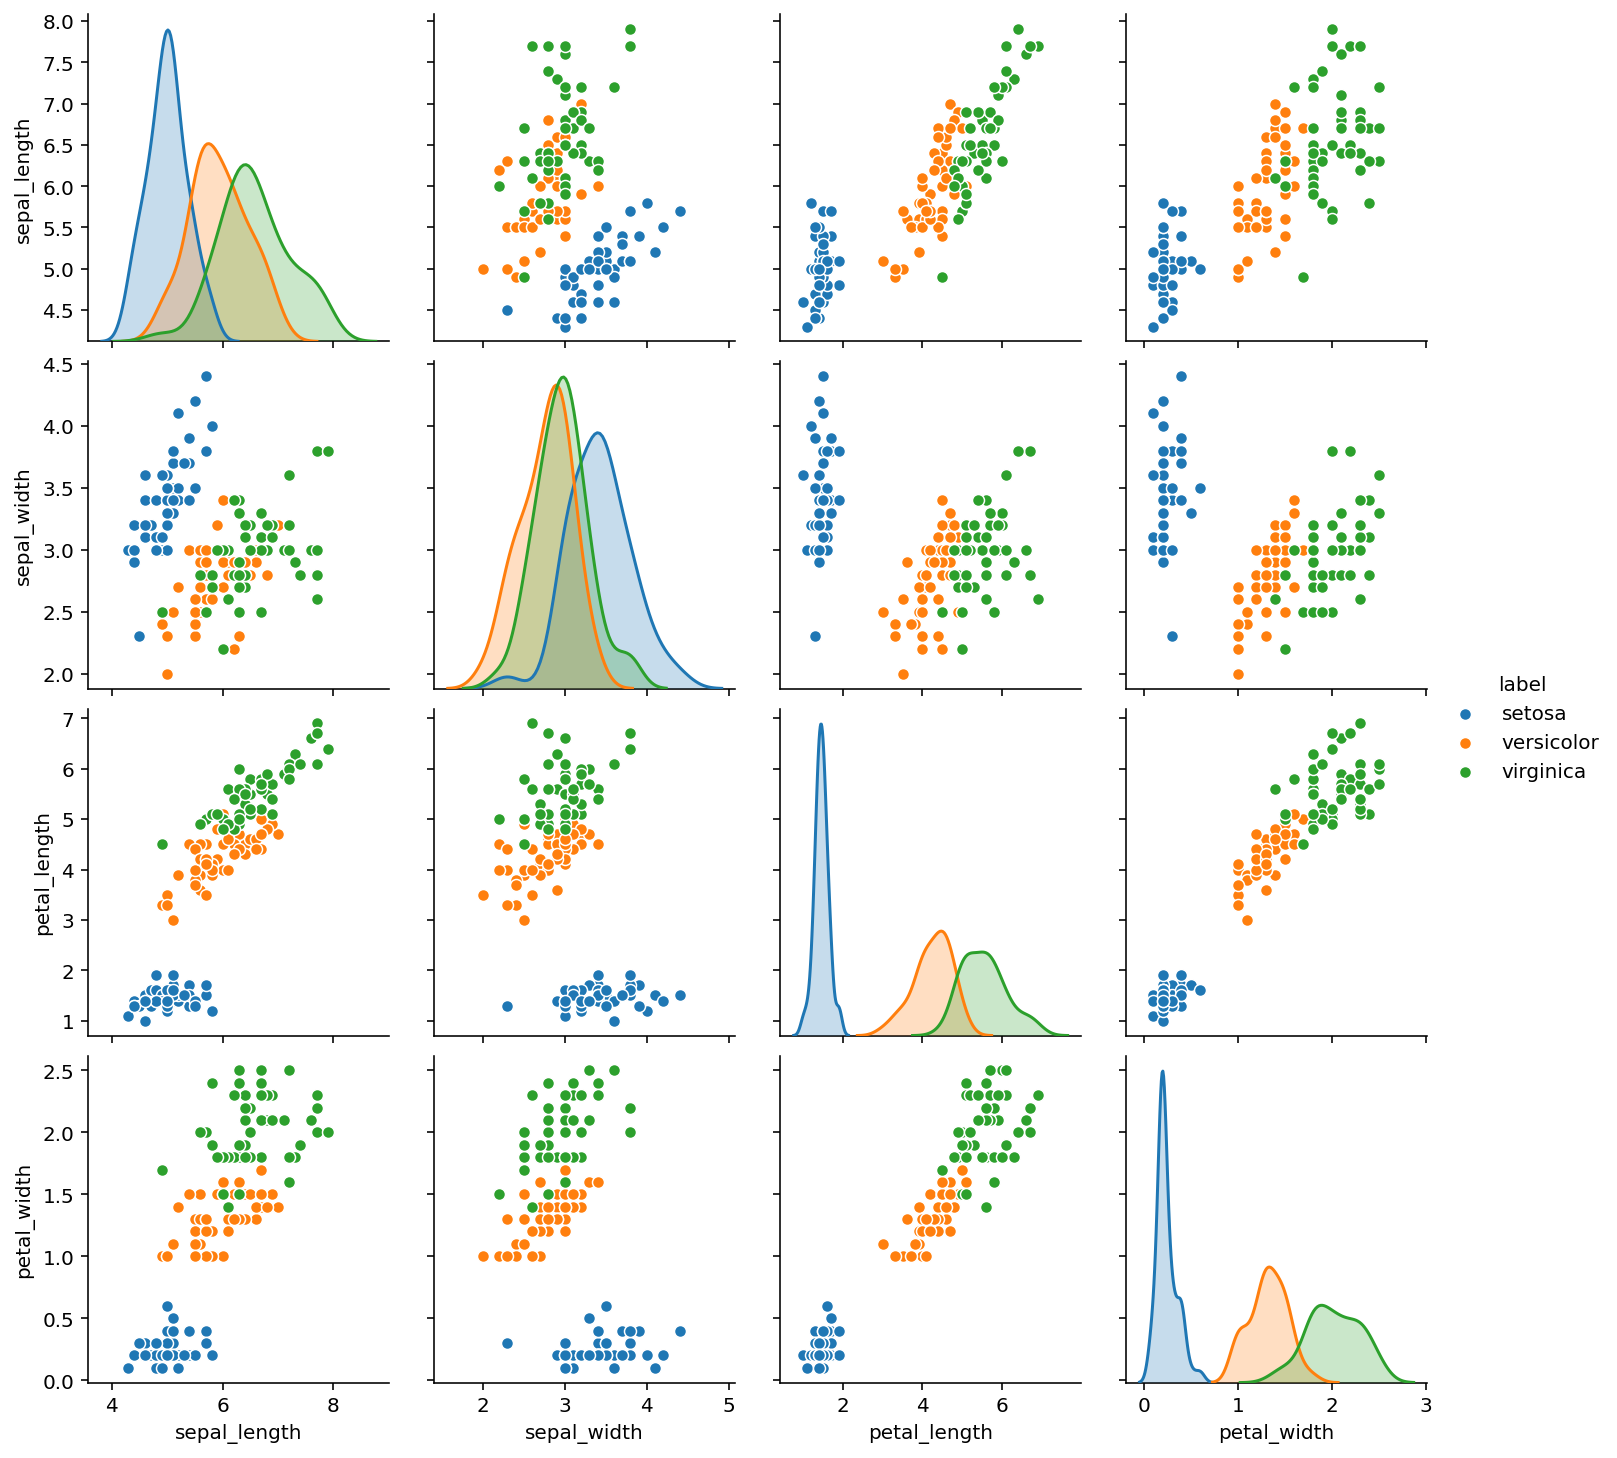

In [182]:
sns.pairplot(df, hue='label')

In [210]:
# X = df.values[:, :-1] #Excluding 'label' column
X = df.drop(['label'], axis=1).values
ss = StandardScaler()
X = ss.fit_transform(X)
y = pd.get_dummies(df['label']).values
print(X.shape, y.shape)

(150, 4) (150, 3)


In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 4) (120, 3) (30, 4) (30, 3)


<Figure size 576x432 with 0 Axes>

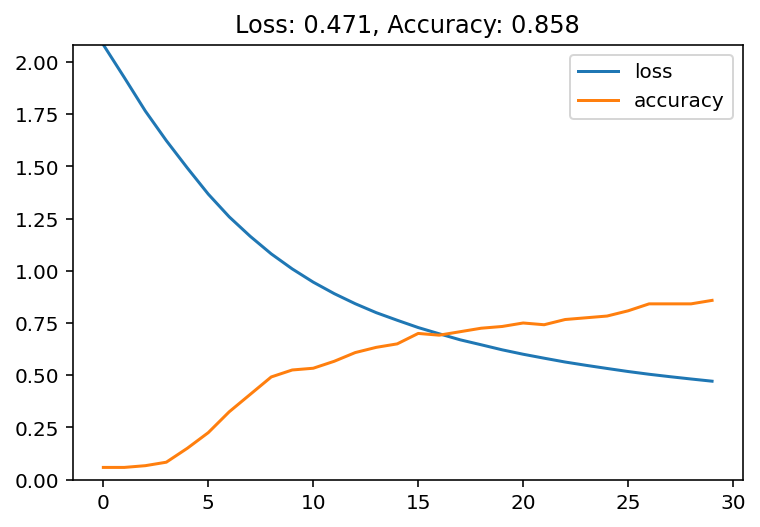

In [212]:
# Softmax regression
sr_model = Sequential()
sr_model.add(Dense(3, input_shape=(X_train.shape[1],), activation='softmax'))
sr_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

sr_history = sr_model.fit(X_train, y_train, epochs=30, verbose=0)
plot_loss_accuracy(sr_history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.67      0.80         9
           2       0.79      1.00      0.88        11

    accuracy                           0.90        30
   macro avg       0.93      0.89      0.89        30
weighted avg       0.92      0.90      0.90        30



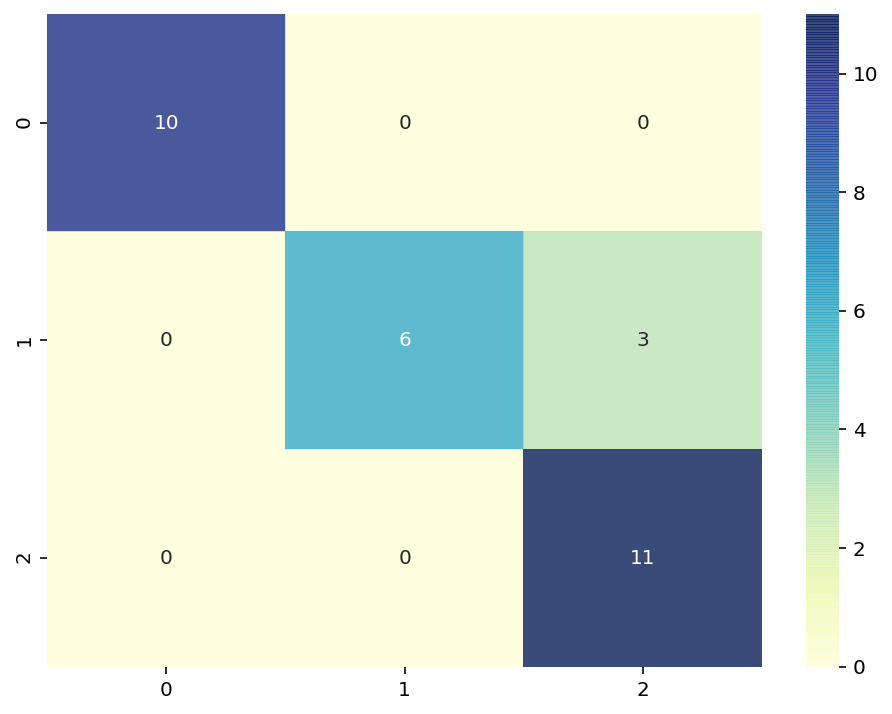

In [220]:
y_pred_class = sr_model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1) # returns the 'indices' of the maximum element in the array.
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(sr_model, X_test, y_test_class)

In [260]:
# Case study - Regression
rawdf = pd.read_csv('kc_house_data.csv')
rawdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [261]:
rawdf.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


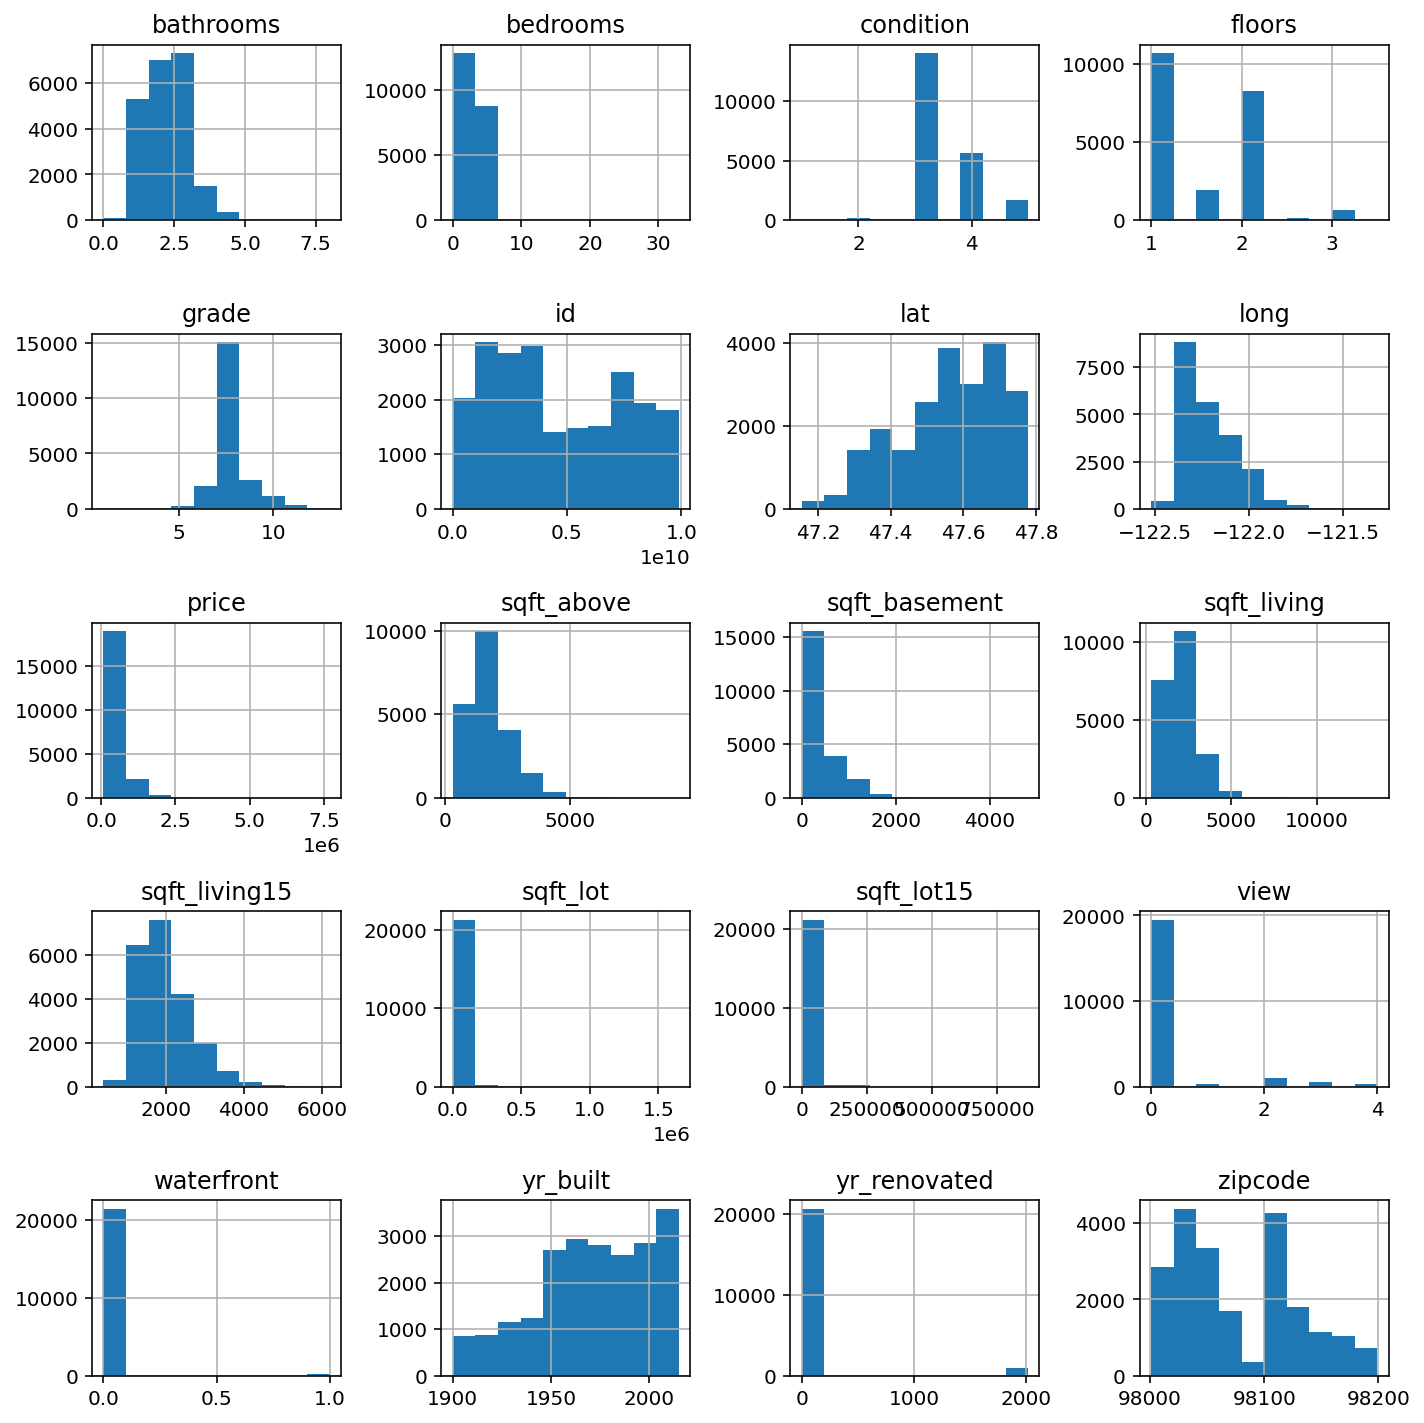

In [262]:
rawdf.hist(figsize=(10, 10))
plt.tight_layout()

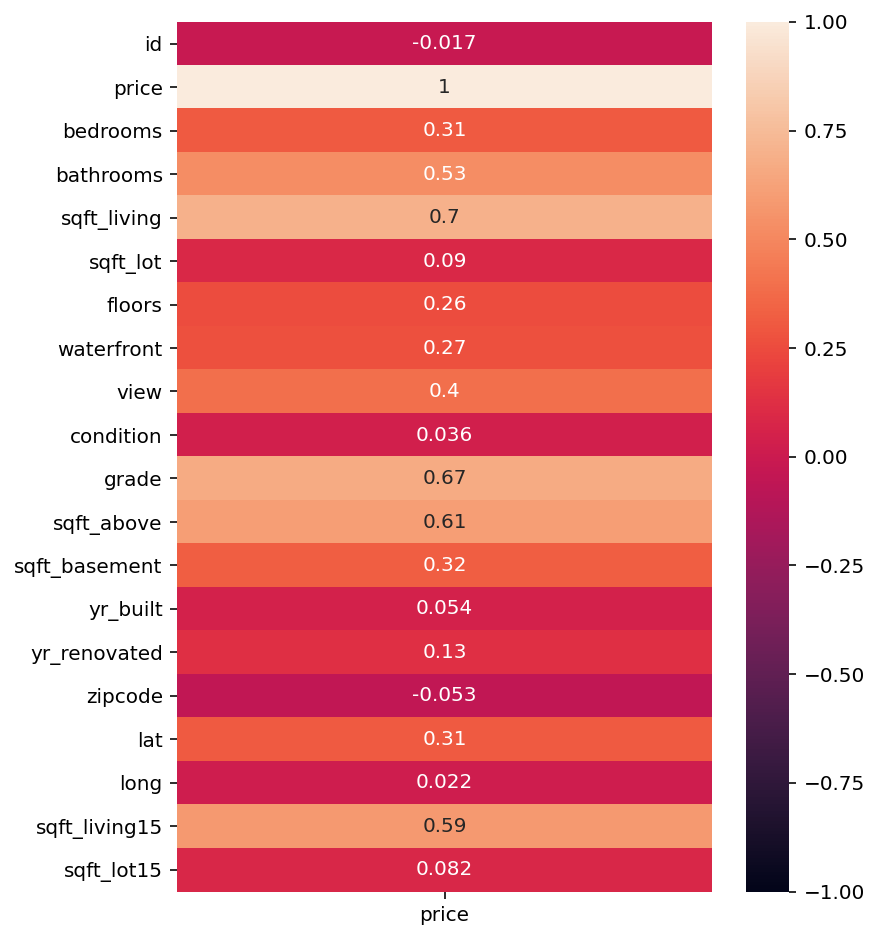

In [263]:
plt.figure(figsize=(6, 8))
sns.heatmap(rawdf.corr()[['price']], annot=True, vmin=-1.0, vmax=1.0)

In [264]:
df = rawdf.copy()

# features that need to be scaled
ss = StandardScaler()
scale_features = ['bathrooms', 'bedrooms', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df[scale_features] = ss.fit_transform(df[scale_features])
df[scale_features].head()

,bathrooms,bedrooms,grade,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15
0,-1.447464,-0.398737,-0.558836,-0.734708,-0.658681,-0.979835,-0.943355,-0.228321,-0.260715
1,0.175607,-0.398737,-0.558836,0.460841,0.245141,0.533634,-0.432686,-0.189885,-0.187868
2,-1.447464,-1.473959,-1.409587,-1.229834,-0.658681,-1.426254,1.070140,-0.123298,-0.172375
3,1.149449,0.676485,-0.558836,-0.891699,1.397515,-0.130550,-0.914174,-0.244014,-0.284522
4,-0.149007,-0.398737,0.291916,-0.130895,-0.658681,-0.435422,-0.272190,-0.169653,-0.192849


In [265]:
# bucketized features
bucketized_features = ['yr_built', 'yr_renovated', 'lat', 'long']
bins = range(1890, 2021, 10)
df['yr_built'] = pd.cut(df.yr_built, bins, labels=bins[:-1])

bins = range(1930, 2021, 10)
bins = [-10] + list(bins)
df['yr_renovated'] = pd.cut(df.yr_renovated, bins, labels=bins[:-1])

bins = np.arange(47.00, 47.90, 0.05)
df['lat'] = pd.cut(df.lat, bins, labels=bins[:-1])

bins = np.arange(-122.60, -121.10, 0.05)
df['long'] = pd.cut(df.long, bins, labels=bins[:-1])
df[bucketized_features].head()

,yr_built,yr_renovated,lat,long
0,1950,-10,47.5,-122.30
1,1950,1990,47.7,-122.35
2,1930,-10,47.7,-122.25
3,1960,-10,47.5,-122.40
4,1980,-10,47.6,-122.05


In [266]:
# categorical features
df['date'] = [datetime.strptime(x, '%Y%m%dT000000').strftime('%Y-%m') for x in rawdf['date'].values]
df['zipcode'] = str(df['zipcode'])
categorical_features = ['zipcode', 'date']
categorical_features.extend(bucketized_features)
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)

# drop features
drop_features = ['id']
df = df.drop(drop_features, axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long_-121.65000000000005,long_-121.60000000000005,long_-121.55000000000005,long_-121.50000000000006,long_-121.45000000000006,long_-121.40000000000006,long_-121.35000000000007,long_-121.30000000000007,long_-121.25000000000007,long_-121.20000000000007
0,221900.0,-0.398737,-1.447464,-0.979835,-0.228321,1.0,0,0,3,-0.558836,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,-0.398737,0.175607,0.533634,-0.189885,2.0,0,0,3,-0.558836,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,-1.473959,-1.447464,-1.426254,-0.123298,1.0,0,0,3,-1.409587,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.676485,1.149449,-0.130550,-0.244014,1.0,0,0,5,-0.558836,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,-0.398737,-0.149007,-0.435422,-0.169653,1.0,0,0,3,0.291916,...,0,0,0,0,0,0,0,0,0,0


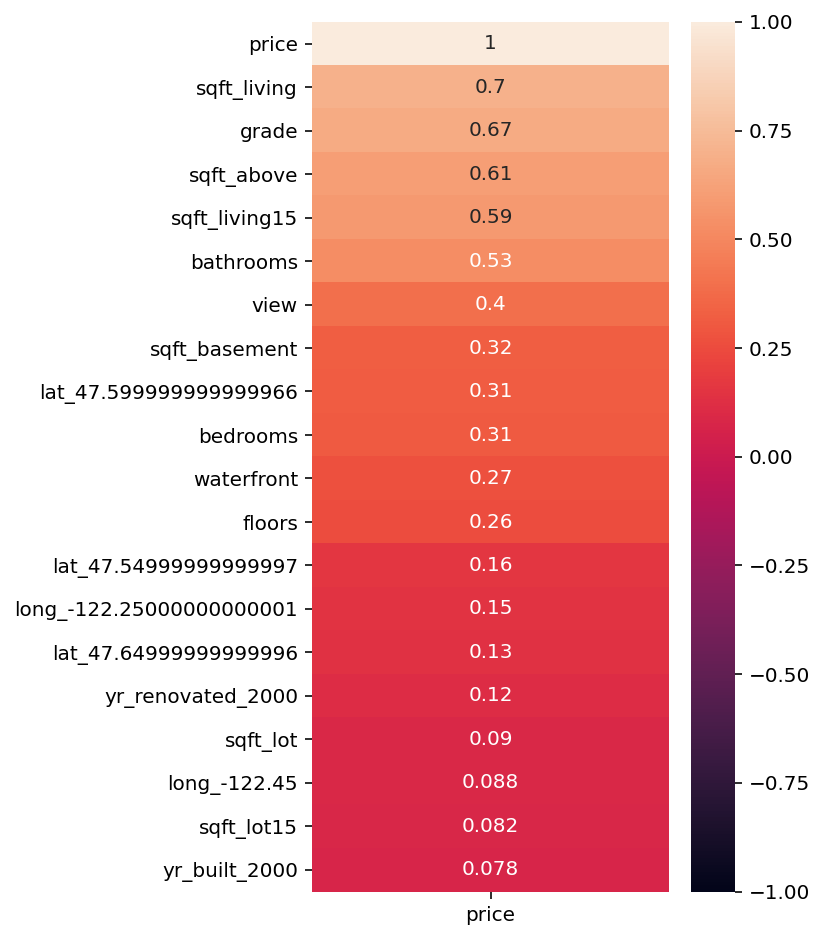

In [267]:
plt.figure(figsize=(4, 8))
tempdf = df.corr()[['price']].sort_values('price', ascending=False).iloc[:20, :]
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)

In [278]:
X = df.drop(['price'], axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# outlier sanitization of the training set
factor = 5
y_train[np.abs(y_train - y_train.mean()) > (factor * y_train.std())] = y_train.mean() + factor*y_train.std()
print(y_train)

# scale the price
ss_price = StandardScaler()
y_train = ss_price.fit_transform(y_train.reshape(-1, 1))
print(y_train)
y_test = ss_price.transform(y_test.reshape(-1, 1))

(17290, 96) (17290,) (4323, 96) (4323,)
[495000. 635000. 382500. ... 431000. 411000. 699900.]
[[-0.12861014]
 [ 0.28661482]
 [-0.46227306]
 ...
 [-0.31842727]
 [-0.37774512]
 [ 0.47910125]]


<Figure size 576x432 with 0 Axes>

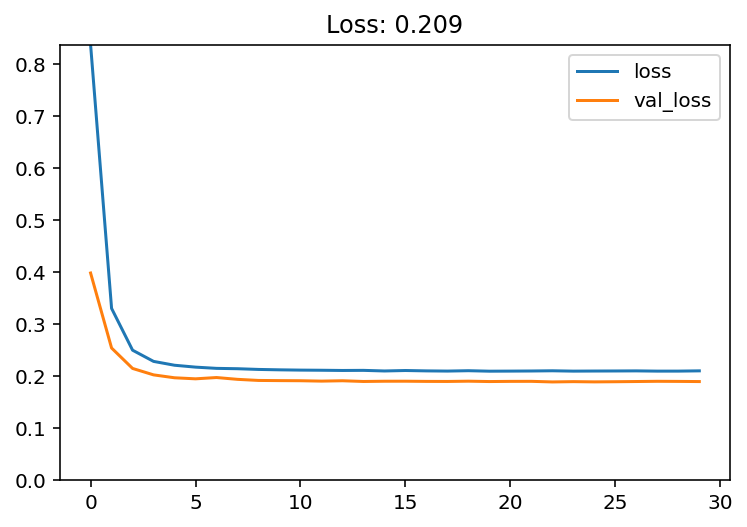

In [281]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(X.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

In [282]:
linr_model.evaluate(X_test, y_test, verbose=0)

0.25346869230270386

In [283]:
# weights data frame
linr_wdf = pd.DataFrame(linr_model.get_weights()[0].T, 
                      columns=df.drop(['price'], axis=1).columns).T.sort_values(0, ascending=False)
linr_wdf.columns = ['feature_weight']
linr_wdf.iloc[:20,:]

,feature_weight
waterfront,1.339402
lat_47.599999999999966,0.723662
lat_47.64999999999996,0.496097
lat_47.54999999999997,0.353191
sqft_living,0.302425
long_-122.25000000000001,0.261337
grade,0.254036
long_-121.65000000000005,0.221172
yr_renovated_2000,0.215908
long_-121.60000000000005,0.168382


<Figure size 576x432 with 0 Axes>

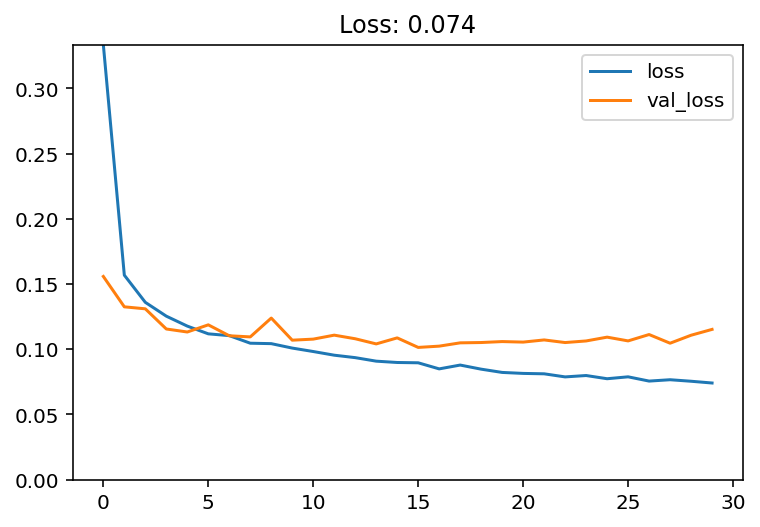

In [285]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
plot_loss(deep_history)

Epoch 00009: early stopping


<Figure size 576x432 with 0 Axes>

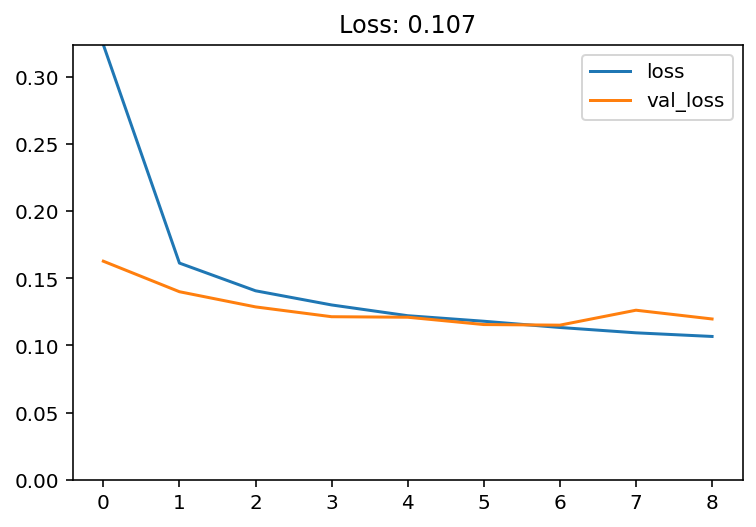

In [288]:
# with early stopping
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2, callbacks=[early_stop])
plot_loss(deep_history)

In [289]:
deep_model.evaluate(X_test, y_test, verbose=0)

0.1555955708026886

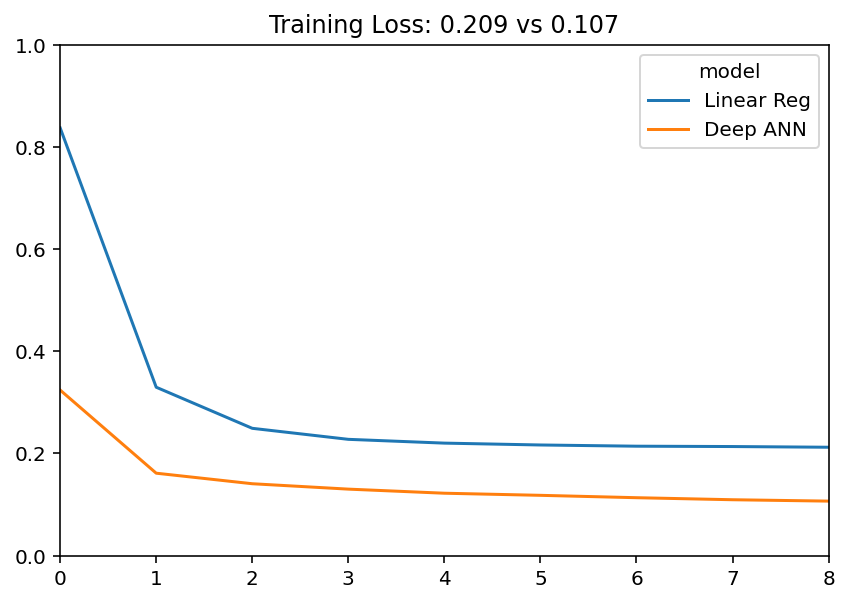

In [290]:
plot_compare_histories([linr_history, deep_history], ['Linear Reg', 'Deep ANN'], plot_accuracy=False)

In [296]:
def output_dollars(num):
    return '$'+str("{:,}".format(int(num)))

print('Average house price:', output_dollars(rawdf['price'].mean()))

real_prices = ss_price.inverse_transform(y_test) # Apply reverse transform to get back the original price

train_prices = ss_price.inverse_transform(y_train) # Apply reverse transform to get back the original price
dumb_prices = np.zeros(real_prices.shape)
dumb_prices.fill(train_prices.mean())
dumb_error = mean_absolute_error(real_prices, dumb_prices)
print('Dumb model error:', output_dollars(dumb_error))

linr_predictions = linr_model.predict(X_test).ravel()
linr_prices = ss_price.inverse_transform(linr_predictions) # Apply reverse transform to get back the original price
linr_error = mean_absolute_error(real_prices, linr_prices)
print('Linear model error:', output_dollars(linr_error))

deep_predictions = deep_model.predict(X_test).ravel()
deep_prices = ss_price.inverse_transform(deep_predictions) # Apply reverse transform to get back the original price
deep_error = mean_absolute_error(real_prices, deep_prices)
print('Deep model error:', output_dollars(deep_error))

tdf = pd.DataFrame([['Naive Model', output_dollars(dumb_error)], 
                    ['Linear Regression', output_dollars(linr_error)], 
                    ['Deep ANN', output_dollars(deep_error)]], 
                   columns=['Model', 'Price Error'])
tdf

Average house price: $540,088
Dumb model error: $229,981
Linear model error: $103,099
Deep model error: $75,004


,Model,Price Error
0,Naive Model,"$229,981"
1,Linear Regression,"$103,099"
2,Deep ANN,"$75,004"
